In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from keras.saving import register_keras_serializable

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')

In [2]:
root_folder = '.'
data_folder = os.path.join(root_folder, 'dataset')

datset_csv_path = os.path.join(data_folder, 'HAM10000_metadata.csv')

folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2']
train_csv_path = os.path.join(data_folder, 'train.csv')
val_csv_path = os.path.join(data_folder, 'val.csv')
test_csv_path = os.path.join(data_folder, 'test.csv')

balanced_folders = ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'Augmented_images']
balanced_train_csv_path = os.path.join(data_folder, 'balanced_train.csv')
balanced_val_csv_path = os.path.join(data_folder, 'balanced_val.csv')

models_folder = os.path.join(root_folder, 'models')
if not os.path.exists(models_folder):
    os.mkdir(models_folder)

In [3]:
df = pd.read_csv(datset_csv_path)
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])

categories = list(label_encoder.classes_)
encodings = label_encoder.transform(label_encoder.classes_)

label_mapping = dict(zip(categories, encodings))
label_mapping

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [4]:
batch_size = 32  
init_lr = 1e-3
epochs = 100
init_lr_ft = 1e-5
batch_size_ft = 8
data_augmentation = False

### Load data

In [5]:
def load_dataframe(csv_path, folders, label_encoder):
    data_df = pd.read_csv(csv_path)
    
    jpg_files = []
    for folder in folders:
        jpg_files.extend(glob(os.path.join(data_folder, folder, '*.jpg')))

    imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                        for x in jpg_files}

    data_df['path'] = data_df['image_id'].map(imageid_path_dict.get)
    data_df['class'] = label_encoder.transform(data_df['dx'])
    
    return data_df

In [6]:
def load_data(csv_path, folders, label_encoder, image_size, keep_aspect=True, fill_value=0):
    df = load_dataframe(csv_path, folders, label_encoder)

    data = []
    for _, row in df.iterrows():
        img_path = row['path']
        img_class = row['class']

        if os.path.isfile(img_path):
            data.append((img_path, img_class))

    x = np.zeros((len(data), image_size, image_size, 3), np.uint8)
    y = np.zeros((len(data), 1), np.uint8)

    for i in range(len(data)):
        file, c = data[i]
        y[i] = c
        img = cv2.imread(file)
        if img is None:
            print(file, c)
        if keep_aspect:
            cy = img.shape[0]
            cx = img.shape[1]
            if cx > cy:
                d = cx - cy
                img = cv2.copyMakeBorder(img, top=d//2, bottom=d-d//2, left=0, right=0,
                                        borderType=cv2.BORDER_CONSTANT, value=fill_value)
            else:
                d = cy - cx
                img = cv2.copyMakeBorder(img, top=0, bottom=0, left=d//2, right=d-d//2,
                                        borderType=cv2.BORDER_CONSTANT, value=fill_value)
        img = cv2.resize(img, (image_size, image_size), interpolation=cv2.INTER_LINEAR)
        x[i] = img

    rand_train_idx = np.random.RandomState(seed=0).permutation(len(data))
    x = x[rand_train_idx]
    y = y[rand_train_idx]

    return data, x, y

In [7]:
def get_data_generator():
    return tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                                                           width_shift_range=0.1,
                                                           height_shift_range=0.1,
                                                           brightness_range=(0.8, 1.5),
                                                           shear_range=0.1,
                                                           zoom_range=0.1,
                                                           fill_mode='nearest',
                                                           horizontal_flip=True,
                                                           vertical_flip=True,
                                                           dtype=np.float32)

### Create and train models

In [8]:
resnet_img_size = 224
efficientnet_img_size = 260
mobilenet_img_size = 224
vgg16_img_size = 224
inceptionv3_img_size = 299

In [9]:
@register_keras_serializable(package='Custom', name='preprocess_input_resnet')
def preprocess_input_resnet(*args, **kwargs):
    return tf.keras.applications.resnet_v2.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_efficientnet')
def preprocess_input_efficientnet(*args, **kwargs):
    return tf.keras.applications.efficientnet_v2.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_mobilenet')
def preprocess_input_mobilenet(*args, **kwargs):
    return tf.keras.applications.mobilenet_v2.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_vgg16')
def preprocess_input_vgg16(*args, **kwargs):
    return tf.keras.applications.vgg16.preprocess_input(*args, **kwargs)

@register_keras_serializable(package='Custom', name='preprocess_input_inceptionv3')
def preprocess_input_inceptionv3(*args, **kwargs):
    return tf.keras.applications.inception_v3.preprocess_input(*args, **kwargs)


def create_model(backbone_name, x_train, classes, trainable_encoder=False):
    input_shape = x_train.shape[1:]

    x = tf.keras.layers.Input(shape=input_shape, name='input')

    if backbone_name == "resnet":
        y = tf.keras.layers.Lambda(preprocess_input_resnet, name='adjust_input')(x)
        backbone = tf.keras.applications.ResNet50V2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "efficientnet":
        y = tf.keras.layers.Lambda(preprocess_input_efficientnet, output_shape=input_shape, name='adjust_input')(x)
        backbone = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "mobilenet":
        y = tf.keras.layers.Lambda(preprocess_input_mobilenet, name='adjust_input')(x)
        backbone = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "vgg16":
        y = tf.keras.layers.Lambda(preprocess_input_vgg16, name='adjust_input')(x)
        backbone = tf.keras.applications.VGG16(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)
    if backbone_name == "inceptionv3":
        y = tf.keras.layers.Lambda(preprocess_input_inceptionv3, name='adjust_input')(x)
        backbone = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet',
                                                    input_tensor=y, pooling='avg', classes=classes)

    if not trainable_encoder:
        for layer in backbone.layers:
            layer.trainable = False

    y = backbone.output

    y = tf.keras.layers.Dropout(rate=0.5)(y)
    y = tf.keras.layers.Dense(classes, activation='softmax', name='output')(y)

    model = tf.keras.models.Model(inputs=x, outputs=y)

    return model

In [10]:
def save_history(hist, folder):
    plt.figure(figsize=(20, 8))

    epochs = range(1, len(hist.history['loss']) + 1)
    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.history['loss'], 'r', label='Train loss')
    plt.plot(epochs, hist.history['val_loss'], 'g', label='Val loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.history['sparse_categorical_accuracy'], 'r', label='Train accuracy')
    plt.plot(epochs, hist.history['val_sparse_categorical_accuracy'], 'g', label='Val accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(os.path.join(folder, 'history.png'))
    plt.show()

In [11]:
def train_model(model_name, models_folder, model, data_augmentation, x_train, y_train, x_val, y_val, batch_size, epochs):
    res_folder = os.path.join(models_folder, model_name)
    if not os.path.exists(res_folder):
        os.mkdir(res_folder)

    path = os.path.join(res_folder, 'trained_model.keras')

    save_model = tf.keras.callbacks.ModelCheckpoint(path, monitor='val_sparse_categorical_accuracy', mode='max',
                                                    verbose=1, save_best_only=True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_sparse_categorical_accuracy', mode='max',
                                                    patience=5, restore_best_weights=True, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_sparse_categorical_accuracy', mode='max',
                                                    factor=0.1, patience=3, verbose=1)
    csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(res_folder, 'training.csv'))

    if data_augmentation:
        data_gen = get_data_generator()
        data_gen.fit(x_train)
        hist = model.fit(data_gen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[save_model, early_stopping, reduce_lr, csv_logger],
                        verbose=1)
    else:
        hist = model.fit(x_train, y_train, batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_val, y_val),
                        callbacks=[save_model, early_stopping, reduce_lr, csv_logger],
                        verbose=1)

    save_history(hist, res_folder)
    
    return model

In [12]:
def evaluate_model(model, batch_size, x_val, y_val, x_test, y_test, categories, encodings):
    res_val = model.evaluate(x_val, y_val, batch_size=batch_size, verbose=1)
    res_test = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=1)
    print(f"Val loss: {res_val[0]}, Val accuracy: {res_val[1]}")
    print(f"Test loss: {res_test[0]}, Test accuracy: {res_test[1]}")

    y_pred_prob = model.predict(x_test, batch_size=batch_size)
    y_pred = np.argmax(y_pred_prob, axis=1)

    conf_matrix = confusion_matrix(y_test, y_pred, labels=encodings)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, cmap="Reds", linecolor='black', linewidth=1, annot=True, fmt='')
    plt.show()

    dx_dict = {
        'nv': 'Melanocytic nevi',
        'mel': 'Melanoma',
        'bkl': 'Benign keratosis-like lesions',
        'bcc': 'Basal cell carcinoma',
        'akiec': 'Actinic keratoses',
        'vasc': 'Vascular lesions',
        'df': 'Dermatofibroma'
    }
    classes = [dx_dict[key] for key in categories]

    label_frac_error = 1 - np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    plt.figure(figsize=(15, 4))
    plt.bar(classes, label_frac_error)
    plt.xlabel('True label')
    plt.ylabel('Fraction classified incorrectly')
    plt.show()

    report = classification_report(y_test, y_pred, target_names=classes)
    print("Classification Report:")
    print(report)

## Original dataset

### ResNet

In [13]:
resnet_train_data, resnet_x_train, resnet_y_train = load_data(train_csv_path, folders, label_encoder, resnet_img_size)
resnet_val_data, resnet_x_val, resnet_y_val = load_data(val_csv_path, folders, label_encoder, resnet_img_size)
resnet_test_data, resnet_x_test, resnet_y_test = load_data(test_csv_path, folders, label_encoder, resnet_img_size)
print(resnet_x_train.shape, resnet_y_train.shape, resnet_x_val.shape, resnet_y_val.shape, resnet_x_test.shape, resnet_y_test.shape)

(7210, 224, 224, 3) (7210, 1) (1803, 224, 224, 3) (1803, 1) (1002, 224, 224, 3) (1002, 1)


In [14]:
resnet_model = create_model("resnet", resnet_x_train, classes=len(categories), trainable_encoder=False)

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ adjust_input[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 14,343 (56.03 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3393 - sparse_categorical_accuracy: 0.6006
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.71104, saving model to .\models\ResNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 649s 3s/step - loss: 1.3383 - sparse_categorical_accuracy: 0.6009 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.7110 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8494 - sparse_categorical_accuracy: 0.7101
Epoch 2: val_sparse_categorical_accuracy improved from 0.71104 to 0.72490, saving model to .\models\ResNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 606s 3s/step - loss: 0.8494 - sparse_categorical_accuracy: 0.7101 - val_loss: 0.7425 - val_sparse_categorical_accuracy: 0.7249 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8007 - sparse_categorical_accuracy: 0.7182
Epoch 3: val_sparse_categorical_accuracy improved from 0.72490 to 0.74265,

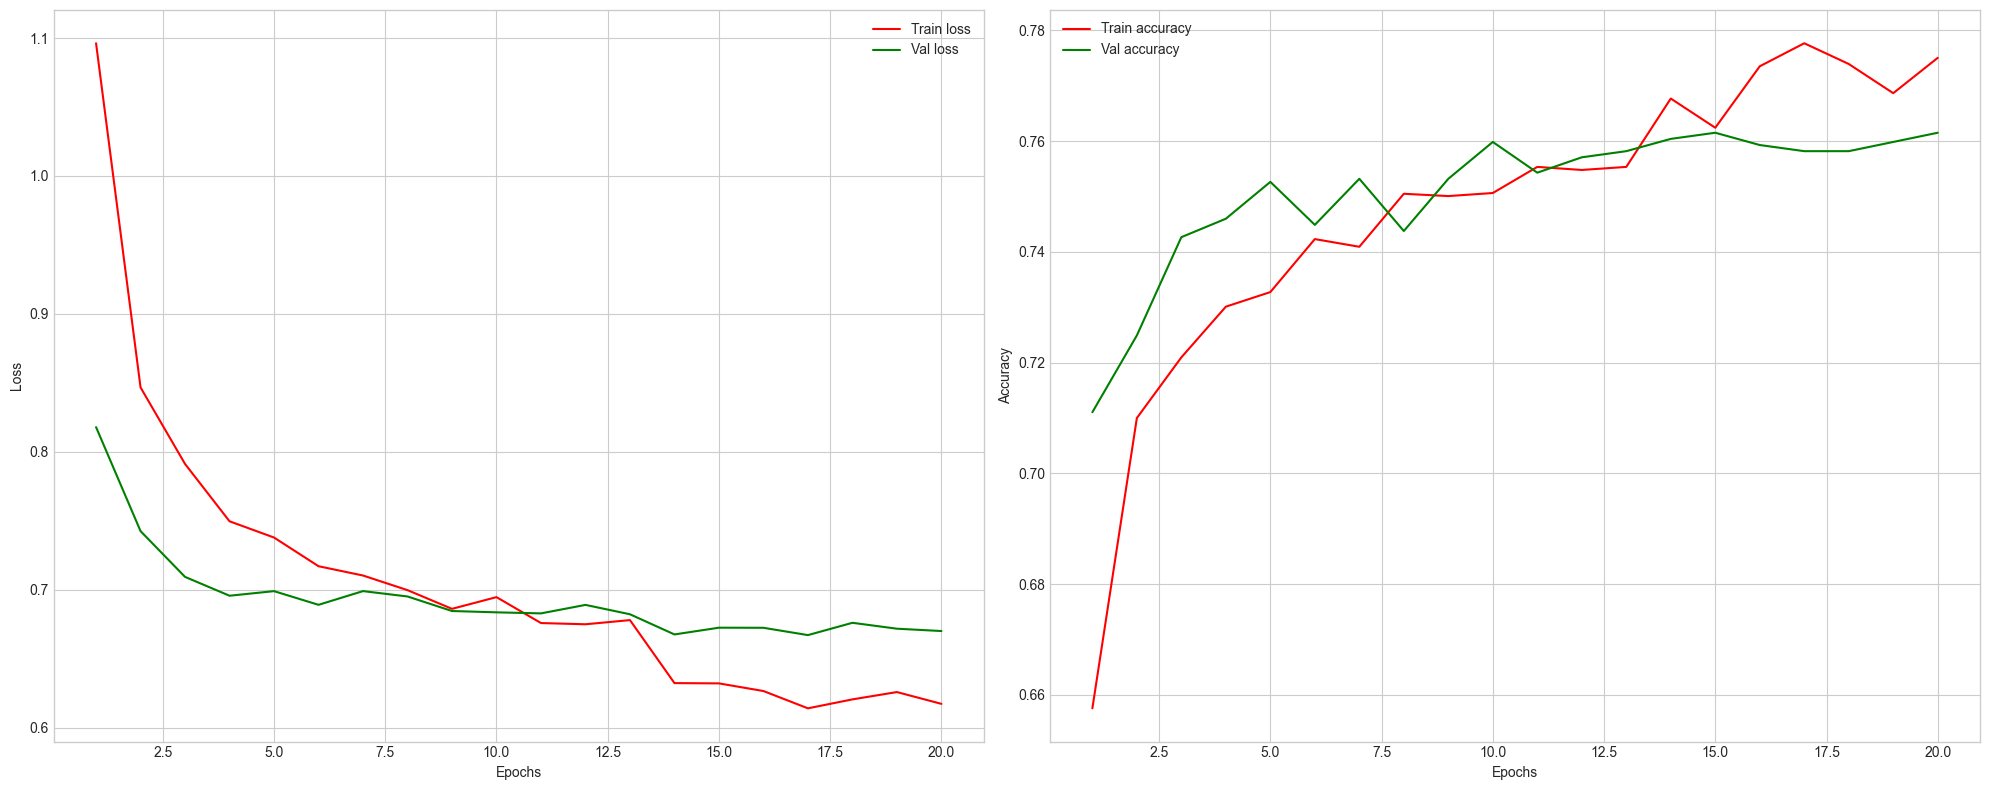

In [15]:
resnet_model = train_model("ResNet", models_folder, resnet_model, data_augmentation, resnet_x_train, resnet_y_train, resnet_x_val, resnet_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - loss: 0.6780 - sparse_categorical_accuracy: 0.7699
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - loss: 0.7268 - sparse_categorical_accuracy: 0.7328
Val loss: 0.672555148601532, Val accuracy: 0.761508584022522
Test loss: 0.710513174533844, Test accuracy: 0.7395209670066833
32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step


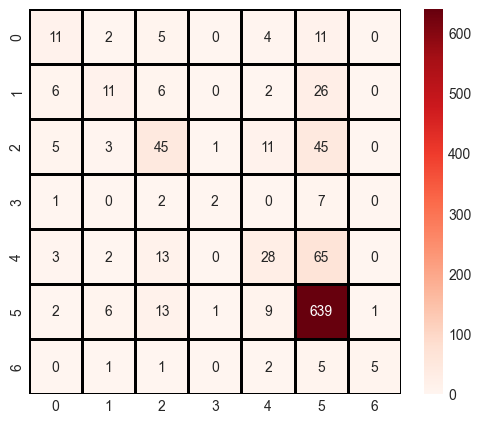

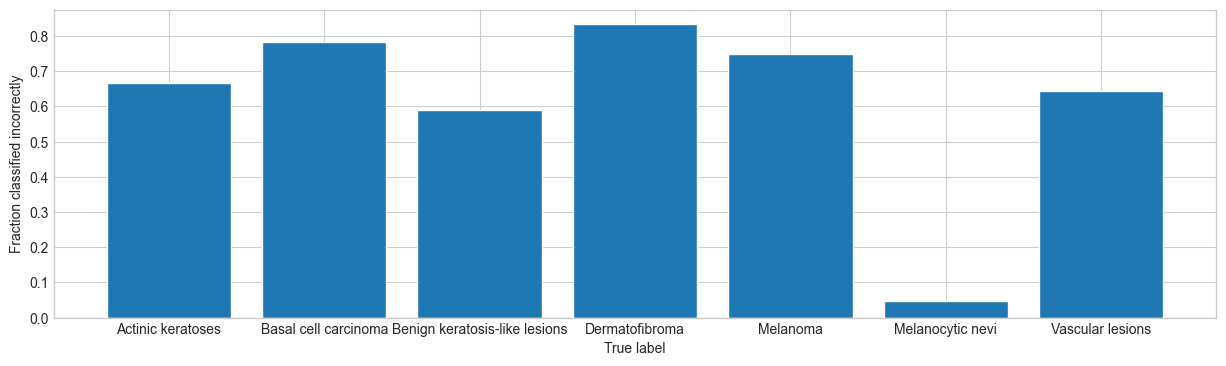

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.39      0.33      0.36        33
         Basal cell carcinoma       0.44      0.22      0.29        51
Benign keratosis-like lesions       0.53      0.41      0.46       110
               Dermatofibroma       0.50      0.17      0.25        12
                     Melanoma       0.50      0.25      0.34       111
             Melanocytic nevi       0.80      0.95      0.87       671
             Vascular lesions       0.83      0.36      0.50        14

                     accuracy                           0.74      1002
                    macro avg       0.57      0.38      0.44      1002
                 weighted avg       0.70      0.74      0.71      1002



In [16]:
evaluate_model(resnet_model, batch_size, resnet_x_val, resnet_y_val, resnet_x_test, resnet_y_test, categories, encodings)

### EfficientNet

In [13]:
efficientnet_train_data, efficientnet_x_train, efficientnet_y_train = load_data(train_csv_path, folders, label_encoder, efficientnet_img_size)
efficientnet_val_data, efficientnet_x_val, efficientnet_y_val = load_data(val_csv_path, folders, label_encoder, efficientnet_img_size)
efficientnet_test_data, efficientnet_x_test, efficientnet_y_test = load_data(test_csv_path, folders, label_encoder, efficientnet_img_size)
print(efficientnet_x_train.shape, efficientnet_y_train.shape, efficientnet_x_val.shape, efficientnet_y_val.shape, efficientnet_x_test.shape, efficientnet_y_test.shape)

(7210, 260, 260, 3) (7210, 1) (1803, 260, 260, 3) (1803, 1) (1002, 260, 260, 3) (1002, 1)


In [14]:
efficientnet_model = create_model("efficientnet", efficientnet_x_train, classes=len(categories), trainable_encoder=False)

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

efficientnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 260, 260,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 260, 260,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ adjust_input[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 260, 260,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati

 Total params: 7,778,432 (29.67 MB)

 Trainable params: 9,863 (38.53 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1365 - sparse_categorical_accuracy: 0.6301
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.71547, saving model to .\models\EfficientNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - loss: 1.1358 - sparse_categorical_accuracy: 0.6303 - val_loss: 0.8149 - val_sparse_categorical_accuracy: 0.7155 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8479 - sparse_categorical_accuracy: 0.6953
Epoch 2: val_sparse_categorical_accuracy improved from 0.71547 to 0.72823, saving model to .\models\EfficientNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 424s 2s/step - loss: 0.8478 - sparse_categorical_accuracy: 0.6953 - val_loss: 0.7421 - val_sparse_categorical_accuracy: 0.7282 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.7861 - sparse_categorical_accuracy: 0.7220
Epoch 3: val_sparse_categorical_accuracy improved from 0.72823

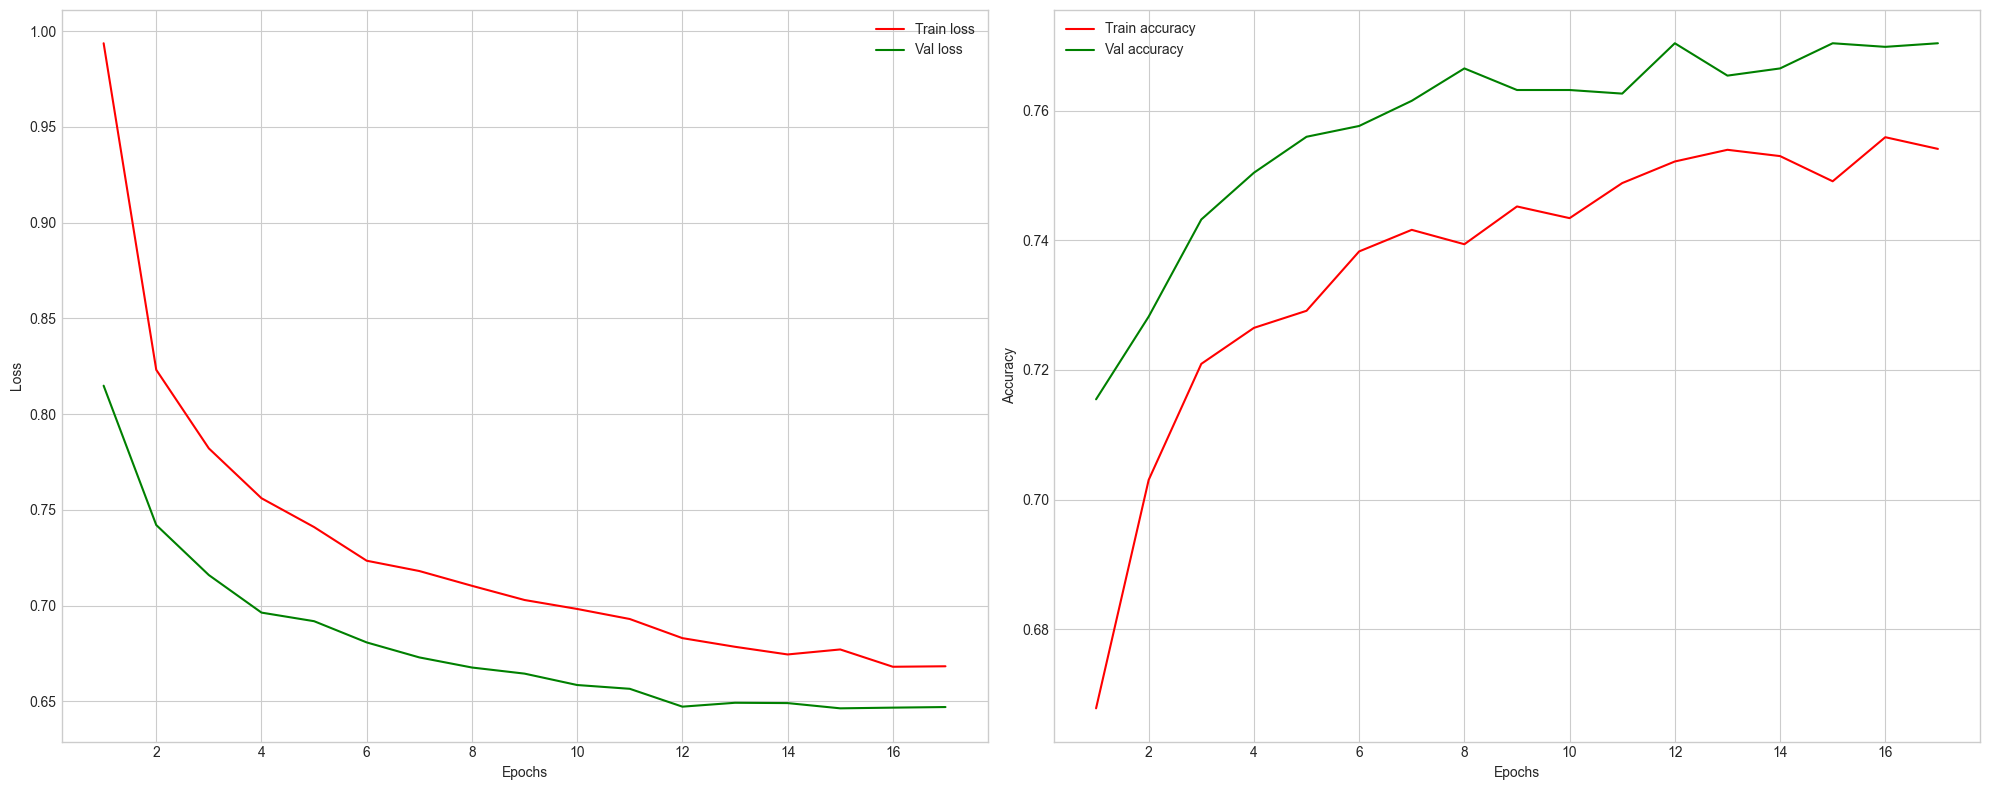

In [23]:
efficientnet_model = train_model("EfficientNet", models_folder, efficientnet_model, data_augmentation, efficientnet_x_train, efficientnet_y_train, efficientnet_x_val, efficientnet_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - loss: 0.6427 - sparse_categorical_accuracy: 0.7664
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - loss: 0.7112 - sparse_categorical_accuracy: 0.7336
Val loss: 0.6472716331481934, Val accuracy: 0.7703827023506165
Test loss: 0.7134084105491638, Test accuracy: 0.7445109486579895
32/32 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step


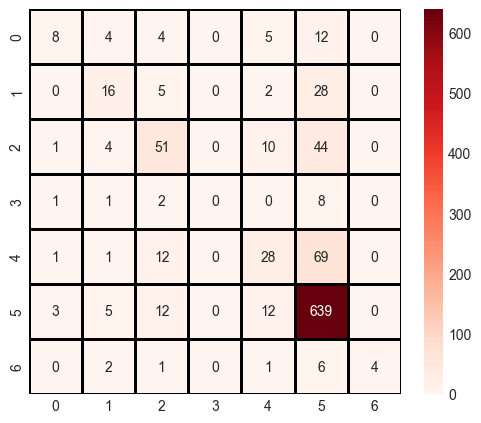

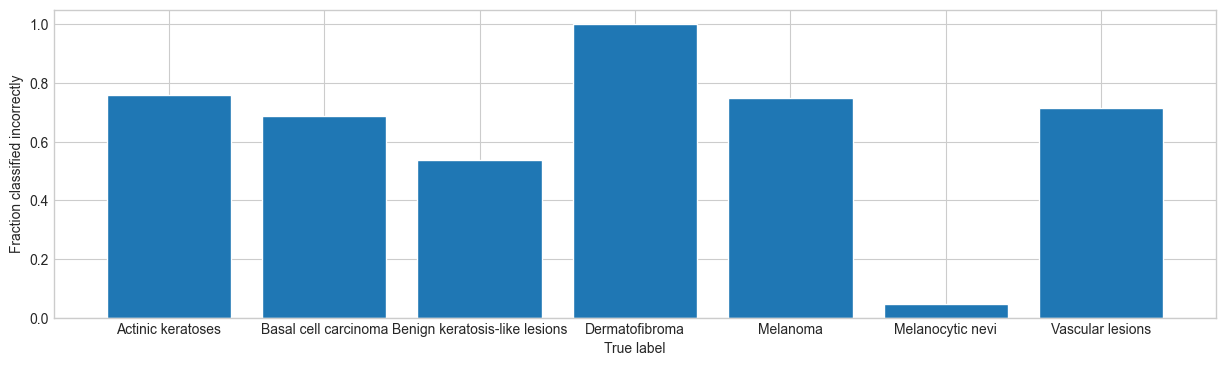

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.57      0.24      0.34        33
         Basal cell carcinoma       0.48      0.31      0.38        51
Benign keratosis-like lesions       0.59      0.46      0.52       110
               Dermatofibroma       0.00      0.00      0.00        12
                     Melanoma       0.48      0.25      0.33       111
             Melanocytic nevi       0.79      0.95      0.87       671
             Vascular lesions       1.00      0.29      0.44        14

                     accuracy                           0.74      1002
                    macro avg       0.56      0.36      0.41      1002
                 weighted avg       0.71      0.74      0.71      1002



In [24]:
evaluate_model(efficientnet_model, batch_size, efficientnet_x_val, efficientnet_y_val, efficientnet_x_test, efficientnet_y_test, categories, encodings)

### MobileNet

In [13]:
mobilenet_train_data, mobilenet_x_train, mobilenet_y_train = load_data(train_csv_path, folders, label_encoder, mobilenet_img_size)
mobilenet_val_data, mobilenet_x_val, mobilenet_y_val = load_data(val_csv_path, folders, label_encoder, mobilenet_img_size)
mobilenet_test_data, mobilenet_x_test, mobilenet_y_test = load_data(test_csv_path, folders, label_encoder, mobilenet_img_size)
print(mobilenet_x_train.shape, mobilenet_y_train.shape, mobilenet_x_val.shape, mobilenet_y_val.shape, mobilenet_x_test.shape, mobilenet_y_test.shape)

(7210, 224, 224, 3) (7210, 1) (1803, 224, 224, 3) (1803, 1) (1002, 224, 224, 3) (1002, 1)


In [14]:
mobilenet_model = create_model("mobilenet", mobilenet_x_train, classes=len(categories), trainable_encoder=False)

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

mobilenet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - loss: 1.4356 - sparse_categorical_accuracy: 0.5851
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.72324, saving model to .\models\MobileNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 135s 565ms/step - loss: 1.4343 - sparse_categorical_accuracy: 0.5854 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.7232 - learning_rate: 0.0010
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - loss: 0.9174 - sparse_categorical_accuracy: 0.6905
Epoch 2: val_sparse_categorical_accuracy improved from 0.72324 to 0.73322, saving model to .\models\MobileNet\trained_model.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 128s 566ms/step - loss: 0.9173 - sparse_categorical_accuracy: 0.6905 - val_loss: 0.7363 - val_sparse_categorical_accuracy: 0.7332 - learning_rate: 0.0010
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - loss: 0.8269 - sparse_categorical_accuracy: 0.7036
Epoch 3: val_sparse_categorical_accuracy improved fro

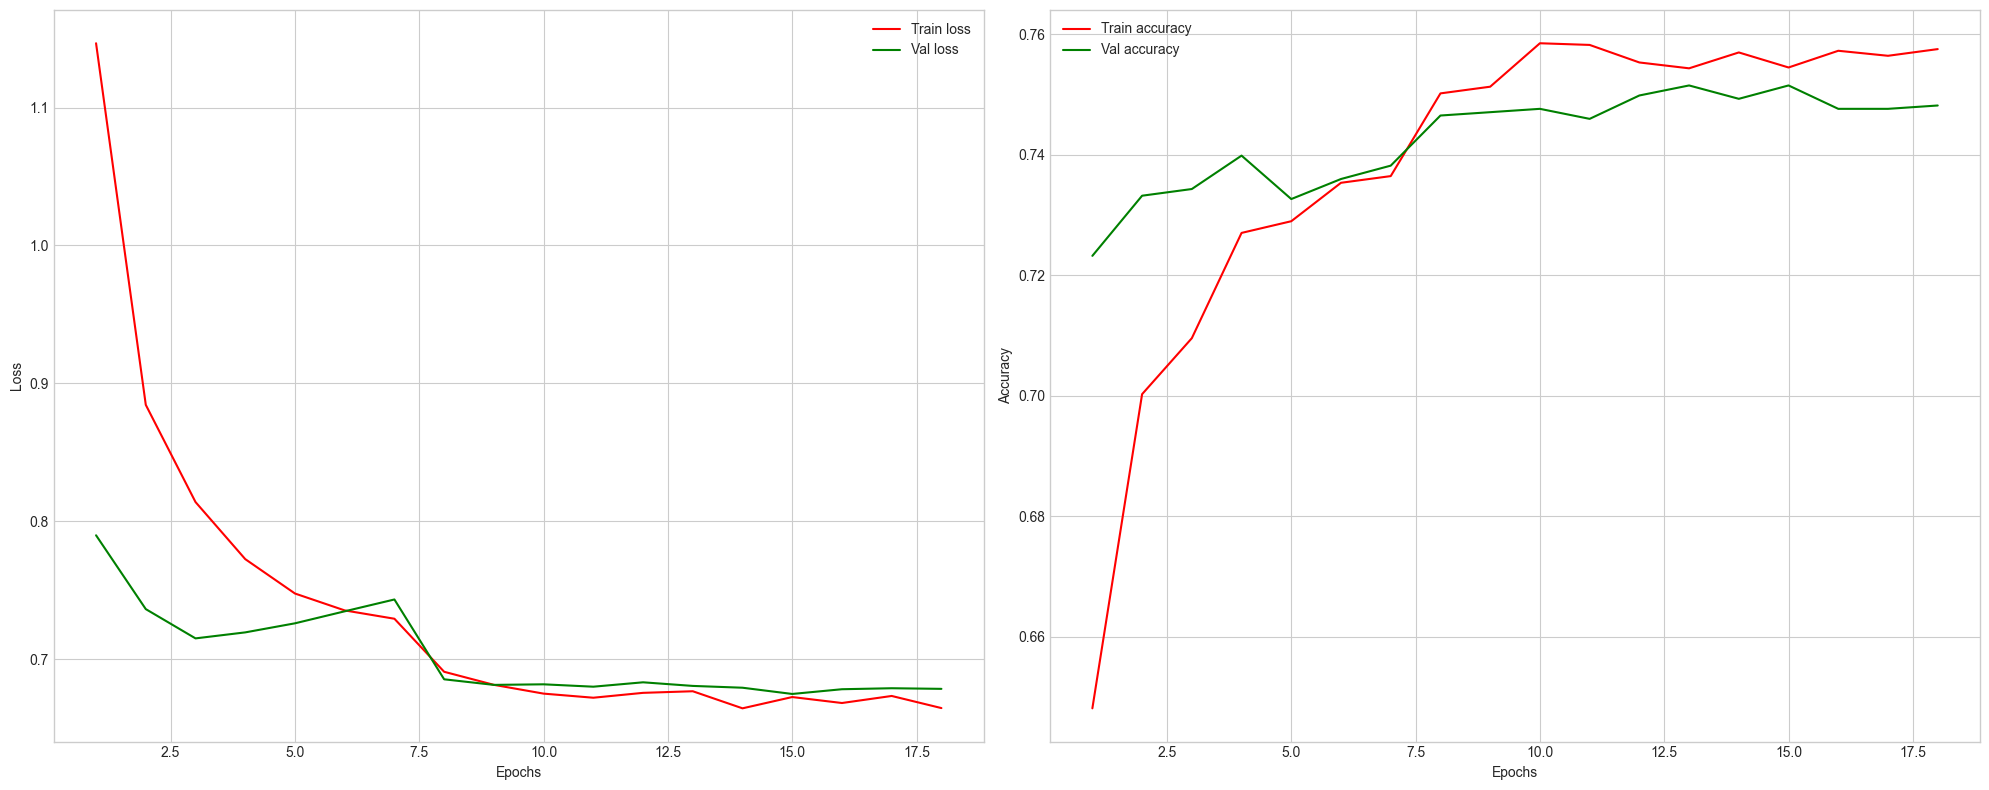

In [15]:
mobilenet_model = train_model("MobileNet", models_folder, mobilenet_model, data_augmentation, mobilenet_x_train, mobilenet_y_train, mobilenet_x_val, mobilenet_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 24s 415ms/step - loss: 0.6945 - sparse_categorical_accuracy: 0.7457
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 411ms/step - loss: 0.7569 - sparse_categorical_accuracy: 0.7270
Val loss: 0.6806544661521912, Val accuracy: 0.7515252232551575
Test loss: 0.7316116690635681, Test accuracy: 0.7325349450111389
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step


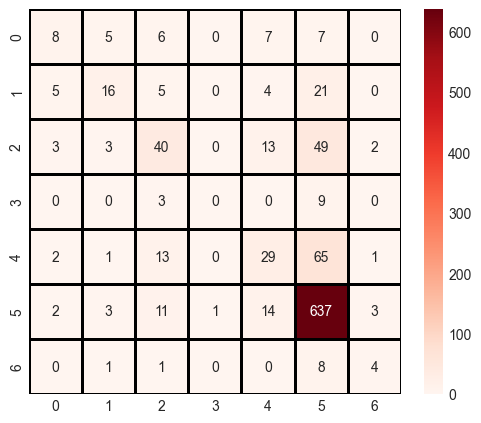

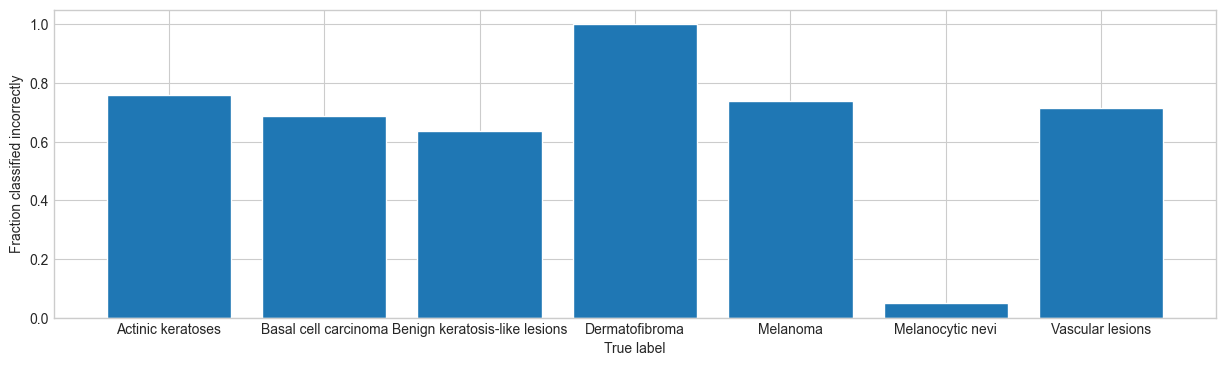

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.40      0.24      0.30        33
         Basal cell carcinoma       0.55      0.31      0.40        51
Benign keratosis-like lesions       0.51      0.36      0.42       110
               Dermatofibroma       0.00      0.00      0.00        12
                     Melanoma       0.43      0.26      0.33       111
             Melanocytic nevi       0.80      0.95      0.87       671
             Vascular lesions       0.40      0.29      0.33        14

                     accuracy                           0.73      1002
                    macro avg       0.44      0.35      0.38      1002
                 weighted avg       0.69      0.73      0.70      1002



In [16]:
evaluate_model(mobilenet_model, batch_size, mobilenet_x_val, mobilenet_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)

### VGG16

In [ ]:
vgg16_train_data, vgg16_x_train, vgg16_y_train = load_data(train_csv_path, folders, label_encoder, vgg16_img_size)
vgg16_val_data, vgg16_x_val, vgg16_y_val = load_data(val_csv_path, folders, label_encoder, vgg16_img_size)
vgg16_test_data, vgg16_x_test, vgg16_y_test = load_data(test_csv_path, folders, label_encoder, vgg16_img_size)
print(vgg16_x_train.shape, vgg16_y_train.shape, vgg16_x_val.shape, vgg16_y_val.shape, vgg16_x_test.shape, vgg16_y_test.shape)

In [ ]:
vgg16_model = create_model("vgg16", vgg16_x_train, classes=len(categories), trainable_encoder=False)

vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

vgg16_model.summary()

In [ ]:
vgg16_model = train_model("VGG16", models_folder, vgg16_model, data_augmentation, vgg16_x_train, vgg16_y_train, vgg16_x_val, vgg16_y_val, batch_size, epochs)

In [ ]:
evaluate_model(vgg16_model, batch_size, vgg16_x_val, vgg16_y_val, vgg16_x_test, vgg16_y_test, categories, encodings)

### InceptionV3

In [ ]:
inceptionv3_train_data, inceptionv3_x_train, inceptionv3_y_train = load_data(train_csv_path, folders, label_encoder, inceptionv3_img_size)
inceptionv3_val_data, inceptionv3_x_val, inceptionv3_y_val = load_data(val_csv_path, folders, label_encoder, inceptionv3_img_size)
inceptionv3_test_data, inceptionv3_x_test, inceptionv3_y_test = load_data(test_csv_path, folders, label_encoder, inceptionv3_img_size)
print(inceptionv3_x_train.shape, inceptionv3_y_train.shape, inceptionv3_x_val.shape, inceptionv3_y_val.shape, inceptionv3_x_test.shape, inceptionv3_y_test.shape)

In [ ]:
inceptionv3_model = create_model("inceptionv3", inceptionv3_x_train, classes=len(categories), trainable_encoder=False)

inceptionv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

inceptionv3_model.summary()

In [ ]:
vgg16_model = train_model("InceptionV3", models_folder, inceptionv3_model, data_augmentation, inceptionv3_x_train, inceptionv3_y_train, inceptionv3_x_val, inceptionv3_y_val, batch_size, epochs)

In [ ]:
evaluate_model(inceptionv3_model, batch_size, inceptionv3_x_val, inceptionv3_y_val, inceptionv3_x_test, inceptionv3_y_test, categories, encodings)

## Balanced dataset

### ResNet

In [17]:
resnet_balanced_train_data, resnet_balanced_x_train, resnet_balanced_y_train = load_data(balanced_train_csv_path, balanced_folders, label_encoder, resnet_img_size)
resnet_balanced_val_data, resnet_balanced_x_val, resnet_balanced_y_val = load_data(balanced_val_csv_path, balanced_folders, label_encoder, resnet_img_size)
resnet_test_data, resnet_x_test, resnet_y_test = load_data(test_csv_path, folders, label_encoder, resnet_img_size)
print(resnet_balanced_x_train.shape, resnet_balanced_y_train.shape, resnet_balanced_x_val.shape, resnet_balanced_y_val.shape, resnet_x_test.shape, resnet_y_test.shape)

(7280, 224, 224, 3) (7280, 1) (1820, 224, 224, 3) (1820, 1) (1002, 224, 224, 3) (1002, 1)


In [18]:
resnet_balanced_model = create_model("resnet", resnet_balanced_x_train, classes=len(categories), trainable_encoder=False)

resnet_balanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

# resnet_balanced_model.summary()

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.9391 - sparse_categorical_accuracy: 0.3092
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.59286, saving model to .\models\ResNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 516s 2s/step - loss: 1.9377 - sparse_categorical_accuracy: 0.3096 - val_loss: 1.1622 - val_sparse_categorical_accuracy: 0.5929 - learning_rate: 0.0010
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.2514 - sparse_categorical_accuracy: 0.5310
Epoch 2: val_sparse_categorical_accuracy improved from 0.59286 to 0.63022, saving model to .\models\ResNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - loss: 1.2512 - sparse_categorical_accuracy: 0.5311 - val_loss: 1.0549 - val_sparse_categorical_accuracy: 0.6302 - learning_rate: 0.0010
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.1262 - sparse_categorical_accuracy: 0.5840
Epoch 3: val_sparse_categorical_accuracy did not improve

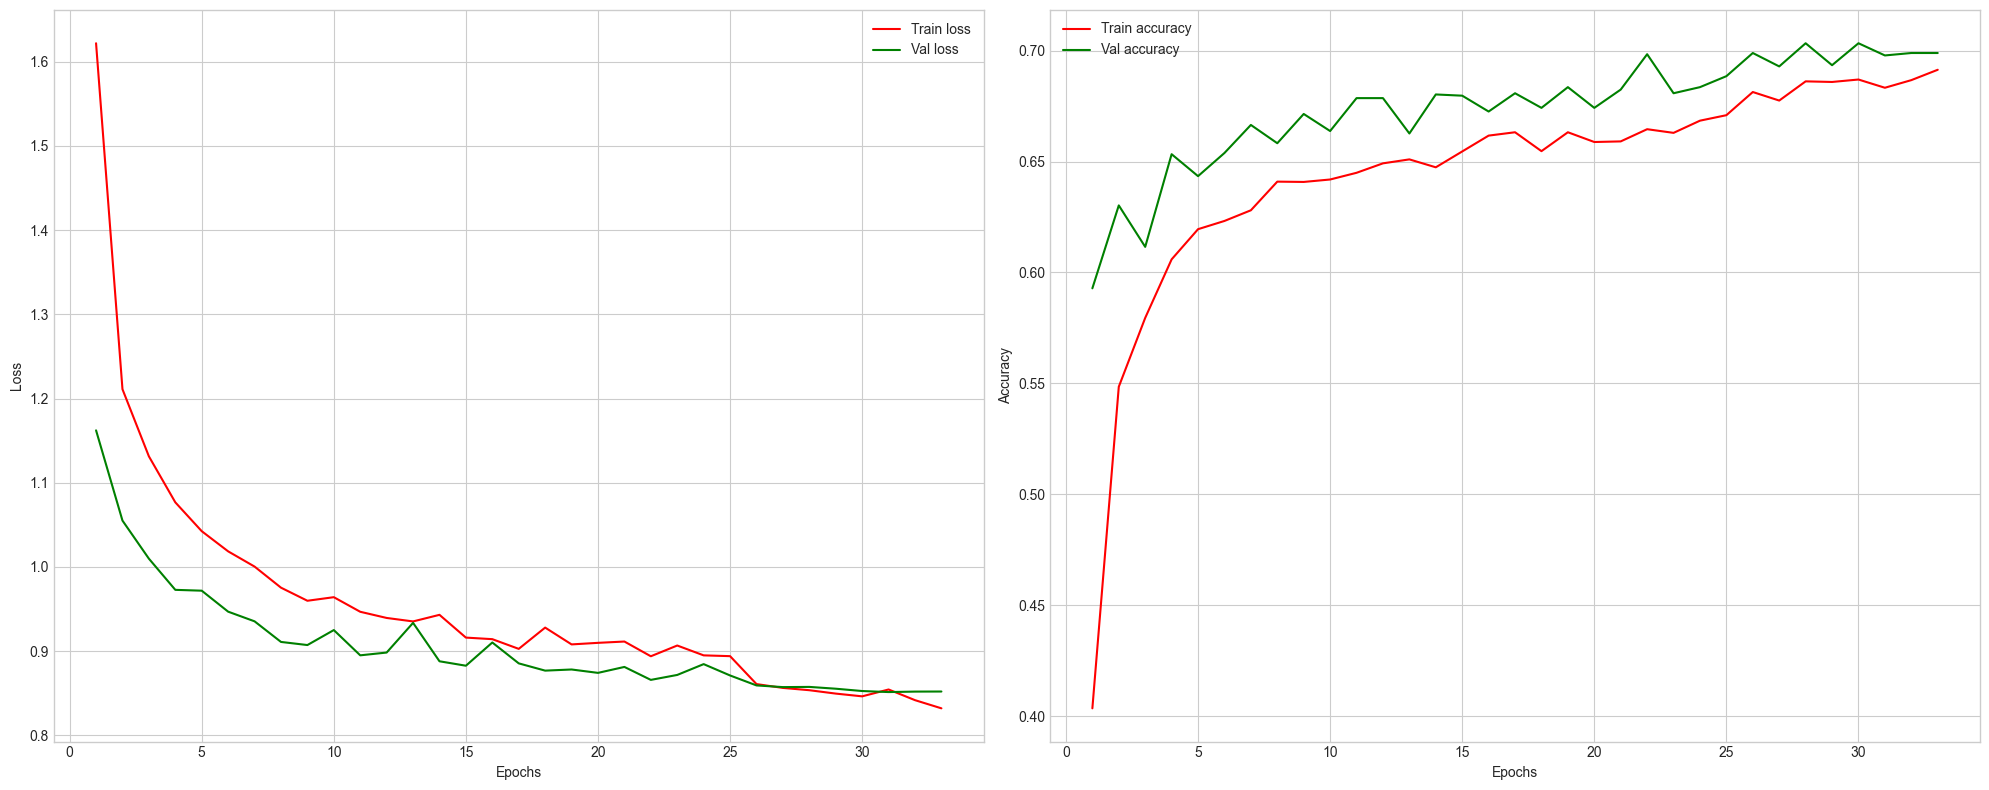

In [19]:
resnet_balanced_model = train_model("ResNet-balanced", models_folder, resnet_balanced_model, data_augmentation, resnet_balanced_x_train, resnet_balanced_y_train, resnet_balanced_x_val, resnet_balanced_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - loss: 0.8562 - sparse_categorical_accuracy: 0.7069
32/32 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.9845 - sparse_categorical_accuracy: 0.6725
Val loss: 0.8573499321937561, Val accuracy: 0.7032967209815979
Test loss: 0.984927773475647, Test accuracy: 0.6726546883583069
32/32 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step


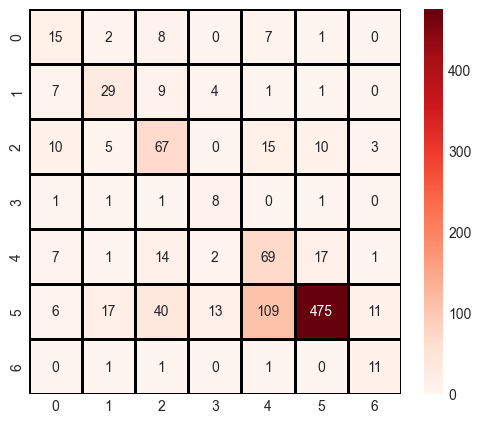

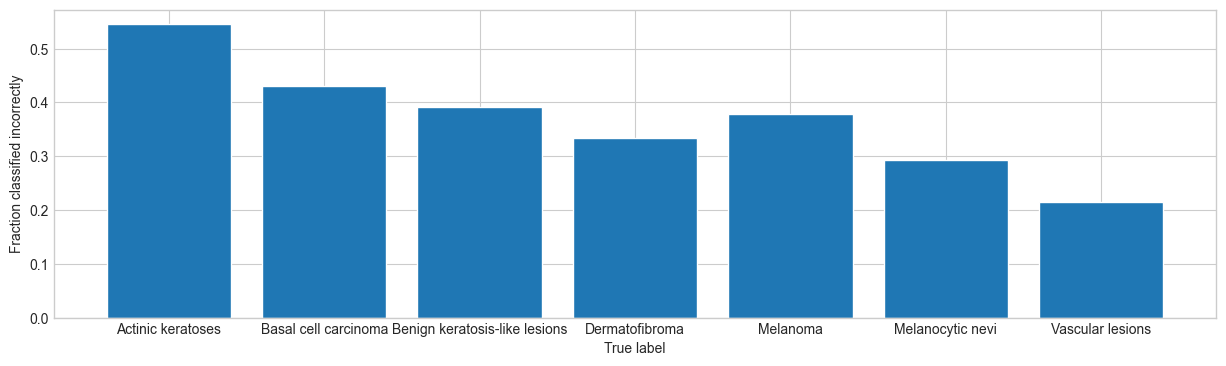

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.33      0.45      0.38        33
         Basal cell carcinoma       0.52      0.57      0.54        51
Benign keratosis-like lesions       0.48      0.61      0.54       110
               Dermatofibroma       0.30      0.67      0.41        12
                     Melanoma       0.34      0.62      0.44       111
             Melanocytic nevi       0.94      0.71      0.81       671
             Vascular lesions       0.42      0.79      0.55        14

                     accuracy                           0.67      1002
                    macro avg       0.47      0.63      0.52      1002
                 weighted avg       0.77      0.67      0.70      1002



In [20]:
evaluate_model(resnet_balanced_model, batch_size, resnet_balanced_x_val, resnet_balanced_y_val, resnet_x_test, resnet_y_test, categories, encodings)

### EfficientNet

In [16]:
efficientnet_balanced_train_data, efficientnet_balanced_x_train, efficientnet_balanced_y_train = load_data(balanced_train_csv_path, balanced_folders, label_encoder, efficientnet_img_size)
efficientnet_balanced_val_data, efficientnet_balanced_x_val, efficientnet_balanced_y_val = load_data(balanced_val_csv_path, balanced_folders, label_encoder, efficientnet_img_size)
print(efficientnet_balanced_x_train.shape, efficientnet_balanced_y_train.shape, efficientnet_balanced_x_val.shape, efficientnet_balanced_y_val.shape)

(7280, 260, 260, 3) (7280, 1) (1820, 260, 260, 3) (1820, 1)


In [17]:
efficientnet_balanced_model = create_model("efficientnet", efficientnet_balanced_x_train, classes=len(categories), trainable_encoder=False)

efficientnet_balanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

# efficientnet_balanced_model.summary()

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.6667 - sparse_categorical_accuracy: 0.3448
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60275, saving model to .\models\EfficientNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - loss: 1.6658 - sparse_categorical_accuracy: 0.3452 - val_loss: 1.1499 - val_sparse_categorical_accuracy: 0.6027 - learning_rate: 0.0010
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.2052 - sparse_categorical_accuracy: 0.5575
Epoch 2: val_sparse_categorical_accuracy improved from 0.60275 to 0.62692, saving model to .\models\EfficientNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 378s 2s/step - loss: 1.2051 - sparse_categorical_accuracy: 0.5575 - val_loss: 1.0400 - val_sparse_categorical_accuracy: 0.6269 - learning_rate: 0.0010
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.1162 - sparse_categorical_accuracy: 0.5839
Epoch 3: val_sparse_categorical_accuracy imp

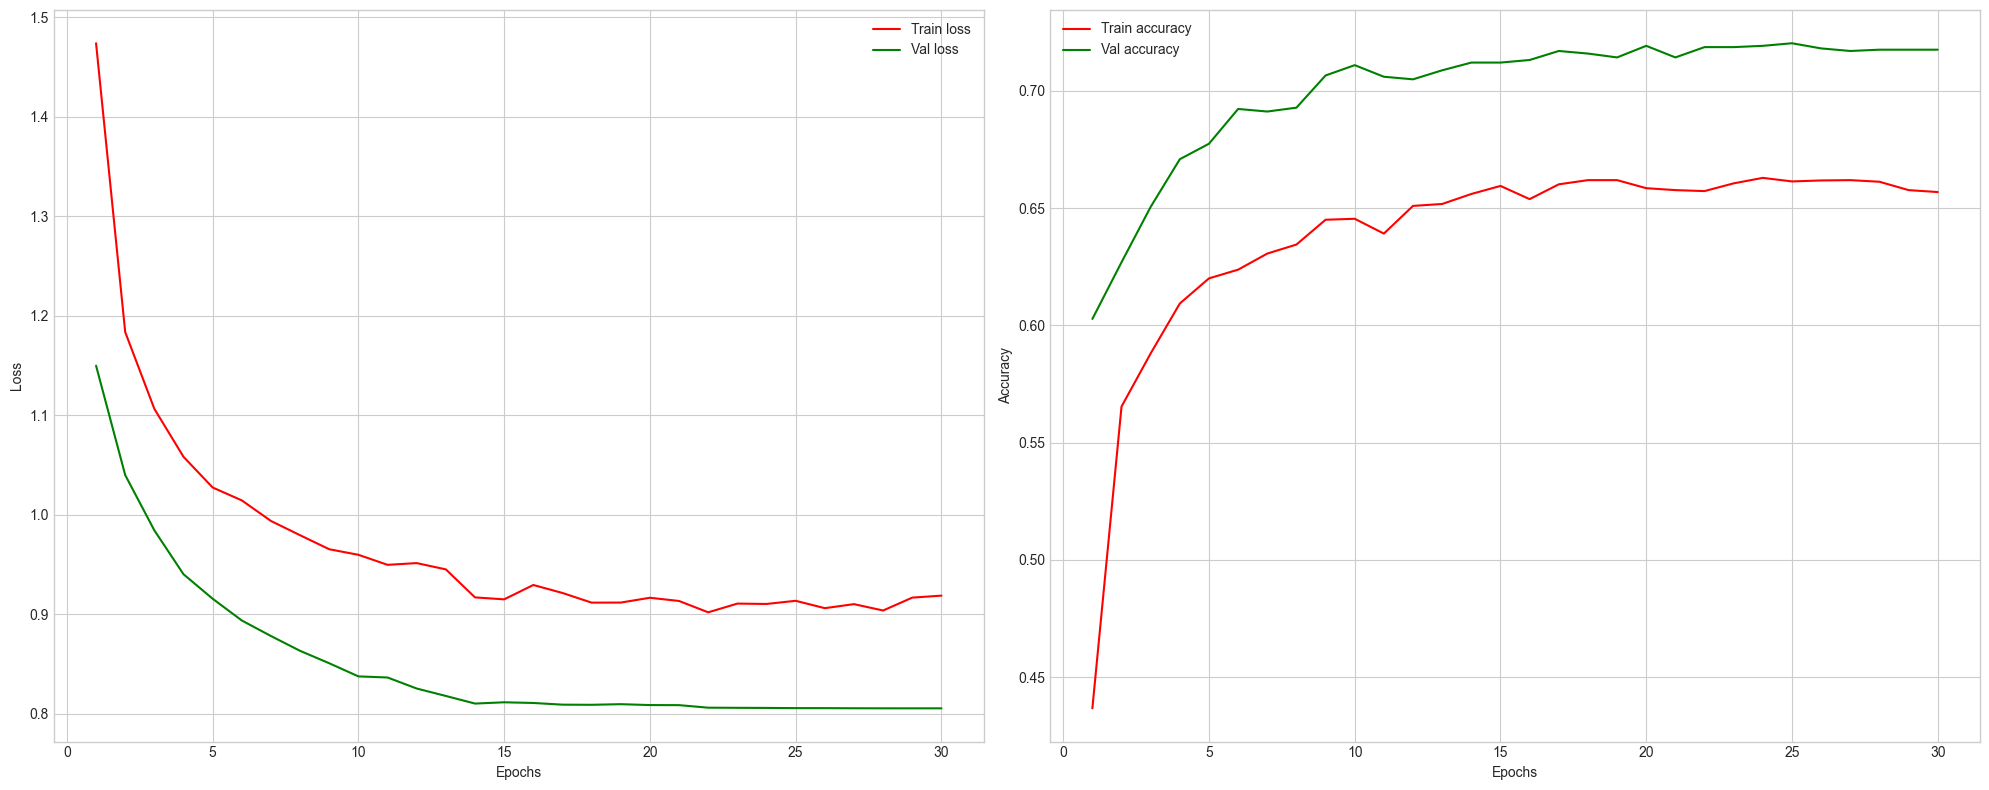

In [18]:
efficientnet_balanced_model = train_model("EfficientNet-balanced", models_folder, efficientnet_balanced_model, data_augmentation, efficientnet_balanced_x_train, efficientnet_balanced_y_train, efficientnet_balanced_x_val, efficientnet_balanced_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - loss: 0.8156 - sparse_categorical_accuracy: 0.7244
32/32 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - loss: 0.8793 - sparse_categorical_accuracy: 0.6814
Val loss: 0.8058832287788391, Val accuracy: 0.7203296422958374
Test loss: 0.8780580163002014, Test accuracy: 0.6856287717819214
32/32 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step


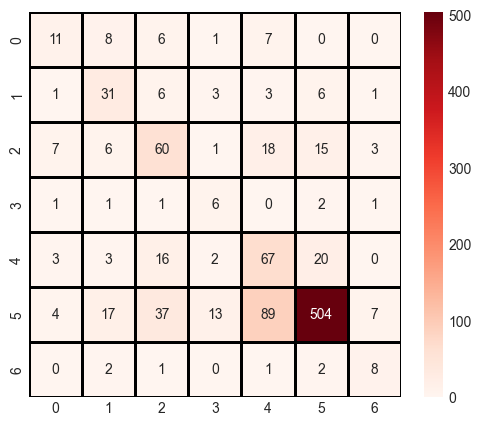

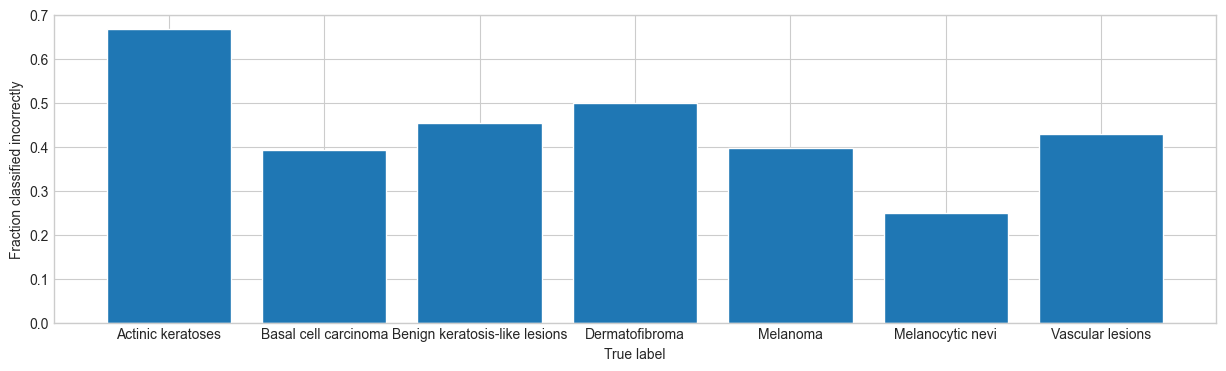

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.41      0.33      0.37        33
         Basal cell carcinoma       0.46      0.61      0.52        51
Benign keratosis-like lesions       0.47      0.55      0.51       110
               Dermatofibroma       0.23      0.50      0.32        12
                     Melanoma       0.36      0.60      0.45       111
             Melanocytic nevi       0.92      0.75      0.83       671
             Vascular lesions       0.40      0.57      0.47        14

                     accuracy                           0.69      1002
                    macro avg       0.46      0.56      0.49      1002
                 weighted avg       0.75      0.69      0.71      1002



In [19]:
evaluate_model(efficientnet_balanced_model, batch_size, efficientnet_balanced_x_val, efficientnet_balanced_y_val, efficientnet_x_test, efficientnet_y_test, categories, encodings)

### MobileNet

In [17]:
mobilenet_balanced_train_data, mobilenet_balanced_x_train, mobilenet_balanced_y_train = load_data(balanced_train_csv_path, balanced_folders, label_encoder, mobilenet_img_size)
mobilenet_balanced_val_data, mobilenet_balanced_x_val, mobilenet_balanced_y_val = load_data(balanced_val_csv_path, balanced_folders, label_encoder, mobilenet_img_size)
print(mobilenet_balanced_x_train.shape, mobilenet_balanced_y_train.shape, mobilenet_balanced_x_val.shape, mobilenet_balanced_y_val.shape)

(7280, 224, 224, 3) (7280, 1) (1820, 224, 224, 3) (1820, 1)


In [18]:
mobilenet_balanced_model = create_model("mobilenet", mobilenet_balanced_x_train, classes=len(categories), trainable_encoder=False)

mobilenet_balanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

# mobilenet_balanced_model.summary()

Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - loss: 1.9545 - sparse_categorical_accuracy: 0.3172
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.60824, saving model to .\models\MobileNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 137s 560ms/step - loss: 1.9532 - sparse_categorical_accuracy: 0.3176 - val_loss: 1.1156 - val_sparse_categorical_accuracy: 0.6082 - learning_rate: 0.0010
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.5348
Epoch 2: val_sparse_categorical_accuracy improved from 0.60824 to 0.65110, saving model to .\models\MobileNet-balanced\trained_model.keras
228/228 ━━━━━━━━━━━━━━━━━━━━ 120s 527ms/step - loss: 1.2450 - sparse_categorical_accuracy: 0.5348 - val_loss: 1.0173 - val_sparse_categorical_accuracy: 0.6511 - learning_rate: 0.0010
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 1.1234 - sparse_categorical_accuracy: 0.5847
Epoch 3: val_sparse_categorical_acc

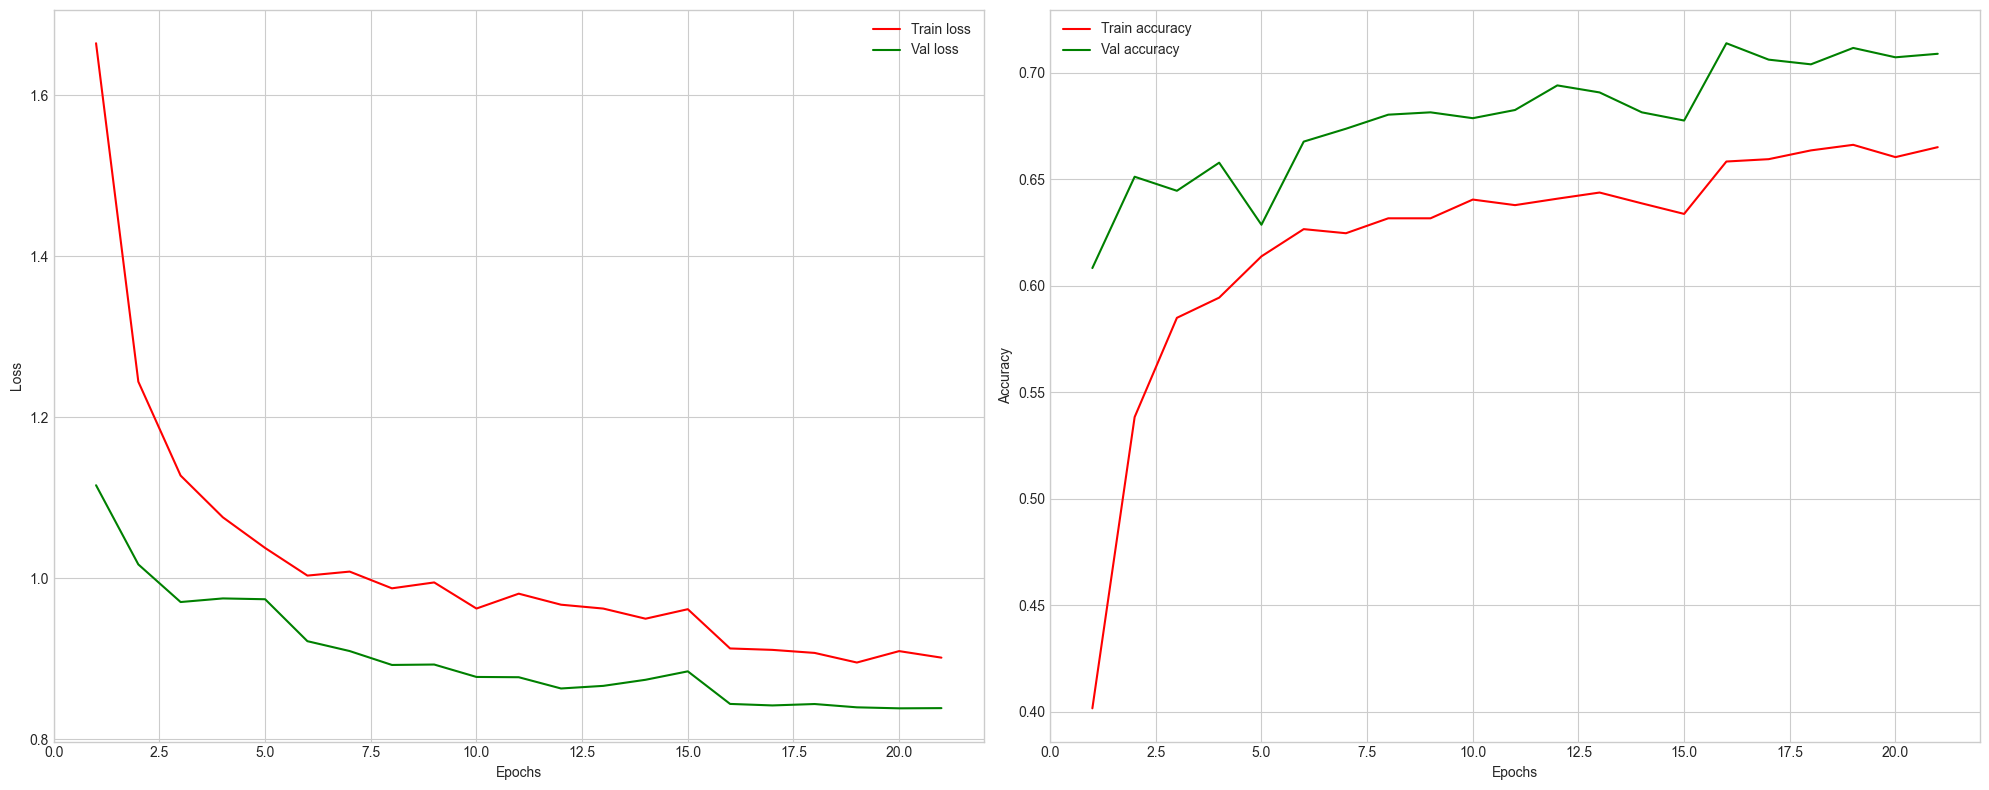

In [19]:
mobilenet_balanced_model = train_model("MobileNet-balanced", models_folder, mobilenet_balanced_model, data_augmentation, mobilenet_balanced_x_train, mobilenet_balanced_y_train, mobilenet_balanced_x_val, mobilenet_balanced_y_val, batch_size, epochs)

57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 430ms/step - loss: 0.8789 - sparse_categorical_accuracy: 0.6984
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 412ms/step - loss: 0.9629 - sparse_categorical_accuracy: 0.6644
Val loss: 0.843923032283783, Val accuracy: 0.7137362360954285
Test loss: 0.9409106373786926, Test accuracy: 0.673652708530426
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 460ms/step


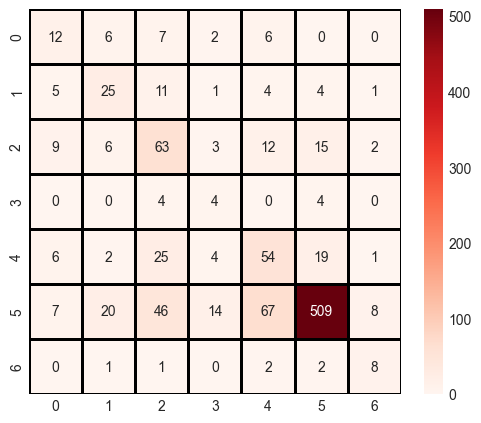

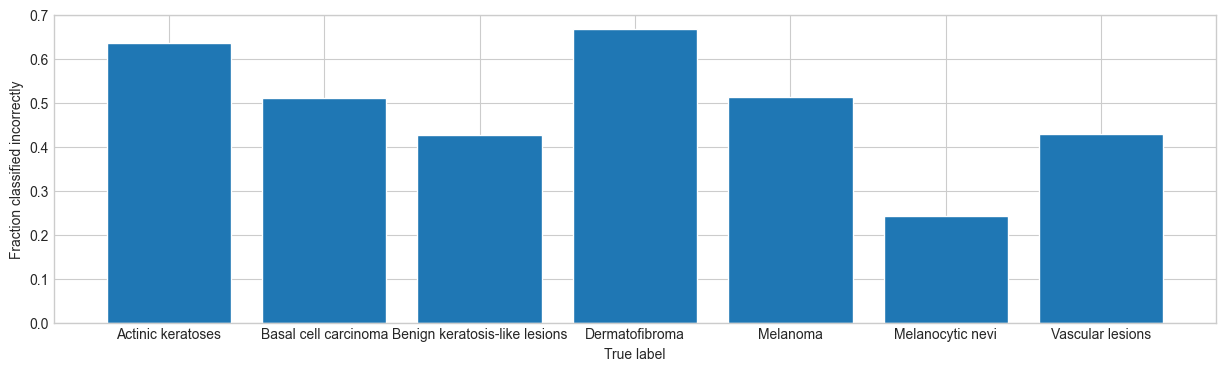

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.31      0.36      0.33        33
         Basal cell carcinoma       0.42      0.49      0.45        51
Benign keratosis-like lesions       0.40      0.57      0.47       110
               Dermatofibroma       0.14      0.33      0.20        12
                     Melanoma       0.37      0.49      0.42       111
             Melanocytic nevi       0.92      0.76      0.83       671
             Vascular lesions       0.40      0.57      0.47        14

                     accuracy                           0.67      1002
                    macro avg       0.42      0.51      0.45      1002
                 weighted avg       0.74      0.67      0.70      1002



In [20]:
evaluate_model(mobilenet_balanced_model, batch_size, mobilenet_balanced_x_val, mobilenet_balanced_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)

### VGG16

In [ ]:
vgg16_balanced_train_data, vgg16_balanced_x_train, vgg16_balanced_y_train = load_data(balanced_train_csv_path, balanced_folders, label_encoder, vgg16_img_size)
vgg16_balanced_val_data, vgg16_balanced_x_val, vgg16_balanced_y_val = load_data(balanced_val_csv_path, balanced_folders, label_encoder, vgg16_img_size)
print(vgg16_balanced_x_train.shape, vgg16_balanced_y_train.shape, vgg16_balanced_x_val.shape, vgg16_balanced_y_val.shape)

In [ ]:
vgg16_balanced_model = create_model("vgg16", vgg16_balanced_x_train, classes=len(categories), trainable_encoder=False)

vgg16_balanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

# vgg16_balanced_model.summary()

In [ ]:
vgg16_balanced_model = train_model("VGG16-balanced", models_folder, vgg16_balanced_model, data_augmentation, vgg16_balanced_x_train, vgg16_balanced_y_train, vgg16_balanced_x_val, vgg16_balanced_y_val, batch_size, epochs)

In [ ]:
evaluate_model(vgg16_balanced_model, batch_size, vgg16_balanced_x_val, vgg16_balanced_y_val, vgg16_x_test, vgg16_y_test, categories, encodings)

### InceptionV3

In [ ]:
inceptionv3_balanced_train_data, inceptionv3_balanced_x_train, inceptionv3_balanced_y_train = load_data(balanced_train_csv_path, balanced_folders, label_encoder, inceptionv3_img_size)
inceptionv3_balanced_val_data, inceptionv3_balanced_x_val, inceptionv3_balanced_y_val = load_data(balanced_val_csv_path, balanced_folders, label_encoder, inceptionv3_img_size)
print(inceptionv3_balanced_x_train.shape, inceptionv3_balanced_y_train.shape, inceptionv3_balanced_x_val.shape, inceptionv3_balanced_y_val.shape)

In [ ]:
inceptionv3_balanced_model = create_model("inceptionv3", inceptionv3_balanced_x_train, classes=len(categories), trainable_encoder=False)

inceptionv3_balanced_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
# inceptionv3_balanced_model.summary()

In [ ]:
inceptionv3_balanced_model = train_model("InceptionV3-balanced", models_folder, inceptionv3_balanced_model, data_augmentation, inceptionv3_balanced_x_train, inceptionv3_balanced_y_train, inceptionv3_balanced_x_val, inceptionv3_balanced_y_val, batch_size, epochs)

In [ ]:
evaluate_model(inceptionv3_balanced_model, batch_size, inceptionv3_balanced_x_val, inceptionv3_balanced_y_val, inceptionv3_x_test, inceptionv3_y_test, categories, encodings)

## Fine tuning using balanced dataset

### ResNet

In [21]:
resnet_balanced_model_ft = create_model("resnet", resnet_balanced_x_train, classes=len(categories), trainable_encoder=True)

resnet_balanced_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

resnet_balanced_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ adjust_input[0][… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 23,579,143 (89.95 MB)

 Trainable params: 23,533,703 (89.77 MB)

 Non-trainable params: 45,440 (177.50 KB)

Epoch 1/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8177 - sparse_categorical_accuracy: 0.3011
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.63956, saving model to .\models\ResNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 1969s 2s/step - loss: 1.8174 - sparse_categorical_accuracy: 0.3012 - val_loss: 1.0020 - val_sparse_categorical_accuracy: 0.6396 - learning_rate: 1.0000e-05
Epoch 2/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0662 - sparse_categorical_accuracy: 0.6118
Epoch 2: val_sparse_categorical_accuracy improved from 0.63956 to 0.72637, saving model to .\models\ResNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 1939s 2s/step - loss: 1.0662 - sparse_categorical_accuracy: 0.6119 - val_loss: 0.7457 - val_sparse_categorical_accuracy: 0.7264 - learning_rate: 1.0000e-05
Epoch 3/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8238 - sparse_categorical_accuracy: 0.7046
Epoch 3: val_sparse_categorical_accuracy

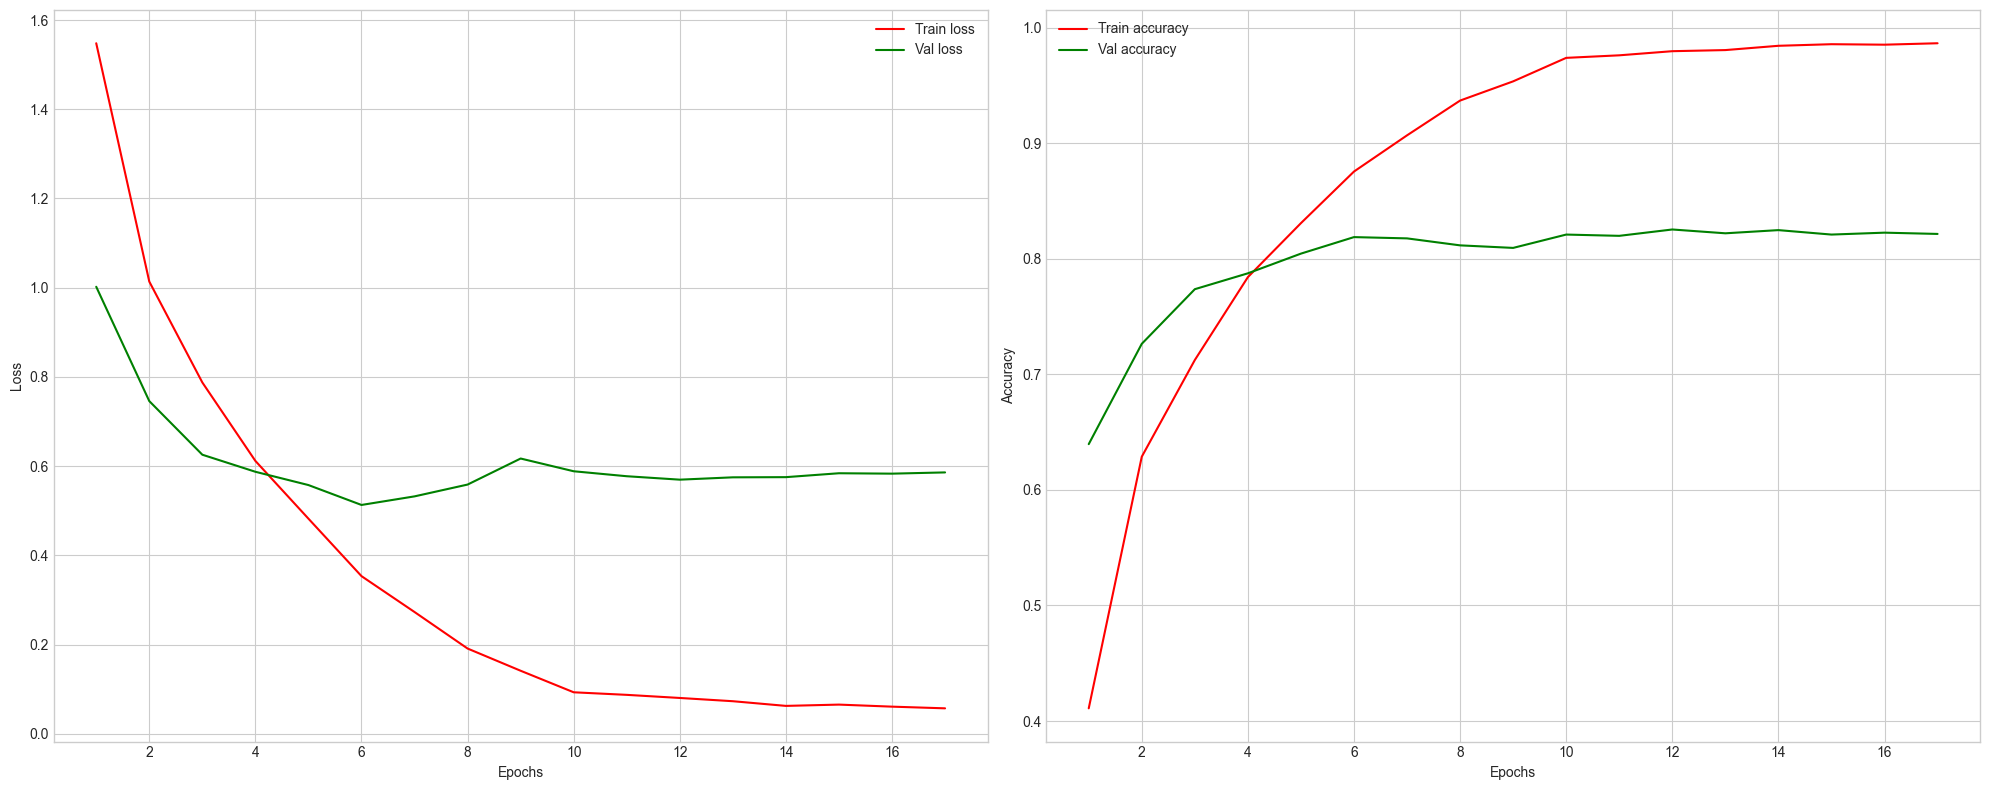

In [22]:
resnet_balanced_model_ft = train_model("ResNet-balanced-ft", models_folder, resnet_balanced_model_ft, data_augmentation, resnet_balanced_x_train, resnet_balanced_y_train, resnet_balanced_x_val, resnet_balanced_y_val, batch_size_ft, epochs)

228/228 ━━━━━━━━━━━━━━━━━━━━ 109s 477ms/step - loss: 0.6054 - sparse_categorical_accuracy: 0.8167
126/126 ━━━━━━━━━━━━━━━━━━━━ 60s 475ms/step - loss: 0.8578 - sparse_categorical_accuracy: 0.7727
Val loss: 0.56964111328125, Val accuracy: 0.8252747058868408
Test loss: 0.8606368899345398, Test accuracy: 0.7704590559005737
126/126 ━━━━━━━━━━━━━━━━━━━━ 61s 483ms/step


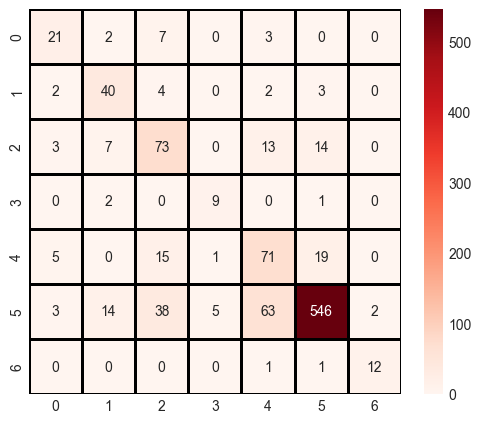

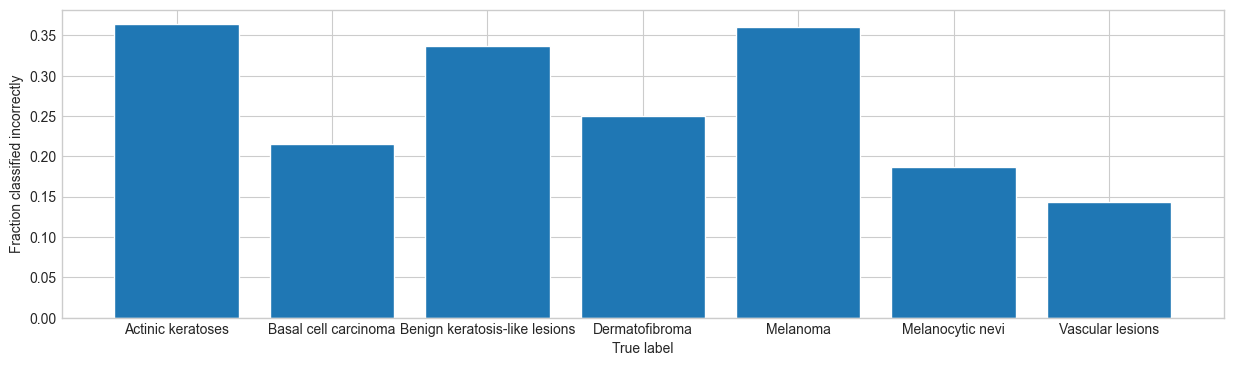

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.62      0.64      0.63        33
         Basal cell carcinoma       0.62      0.78      0.69        51
Benign keratosis-like lesions       0.53      0.66      0.59       110
               Dermatofibroma       0.60      0.75      0.67        12
                     Melanoma       0.46      0.64      0.54       111
             Melanocytic nevi       0.93      0.81      0.87       671
             Vascular lesions       0.86      0.86      0.86        14

                     accuracy                           0.77      1002
                    macro avg       0.66      0.73      0.69      1002
                 weighted avg       0.81      0.77      0.78      1002



In [30]:
evaluate_model(resnet_balanced_model_ft, batch_size_ft, resnet_balanced_x_val, resnet_balanced_y_val, resnet_x_test, resnet_y_test, categories, encodings)

### EfficientNet

In [20]:
efficientnet_balanced_model_ft = create_model("efficientnet", efficientnet_balanced_x_train, classes=len(categories), trainable_encoder=True)

efficientnet_balanced_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

efficientnet_balanced_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 260, 260,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 260, 260,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 260, 260,  │          0 │ adjust_input[0][… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 260, 260,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 260, 260,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 261, 261,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 130, 130,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 130, 130,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 130, 130,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 130, 130,  │          0 │ block1a_activati

 Total params: 7,778,432 (29.67 MB)

 Trainable params: 7,710,857 (29.41 MB)

 Non-trainable params: 67,575 (263.97 KB)

Epoch 1/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.8707 - sparse_categorical_accuracy: 0.2436
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.55110, saving model to .\models\EfficientNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 2394s 3s/step - loss: 1.8705 - sparse_categorical_accuracy: 0.2437 - val_loss: 1.3145 - val_sparse_categorical_accuracy: 0.5511 - learning_rate: 1.0000e-05
Epoch 2/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.3164 - sparse_categorical_accuracy: 0.5333
Epoch 2: val_sparse_categorical_accuracy improved from 0.55110 to 0.66813, saving model to .\models\EfficientNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 1931s 2s/step - loss: 1.3163 - sparse_categorical_accuracy: 0.5333 - val_loss: 0.9552 - val_sparse_categorical_accuracy: 0.6681 - learning_rate: 1.0000e-05
Epoch 3/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 1.0283 - sparse_categorical_accuracy: 0.6280
Epoch 3: val_sparse_categori

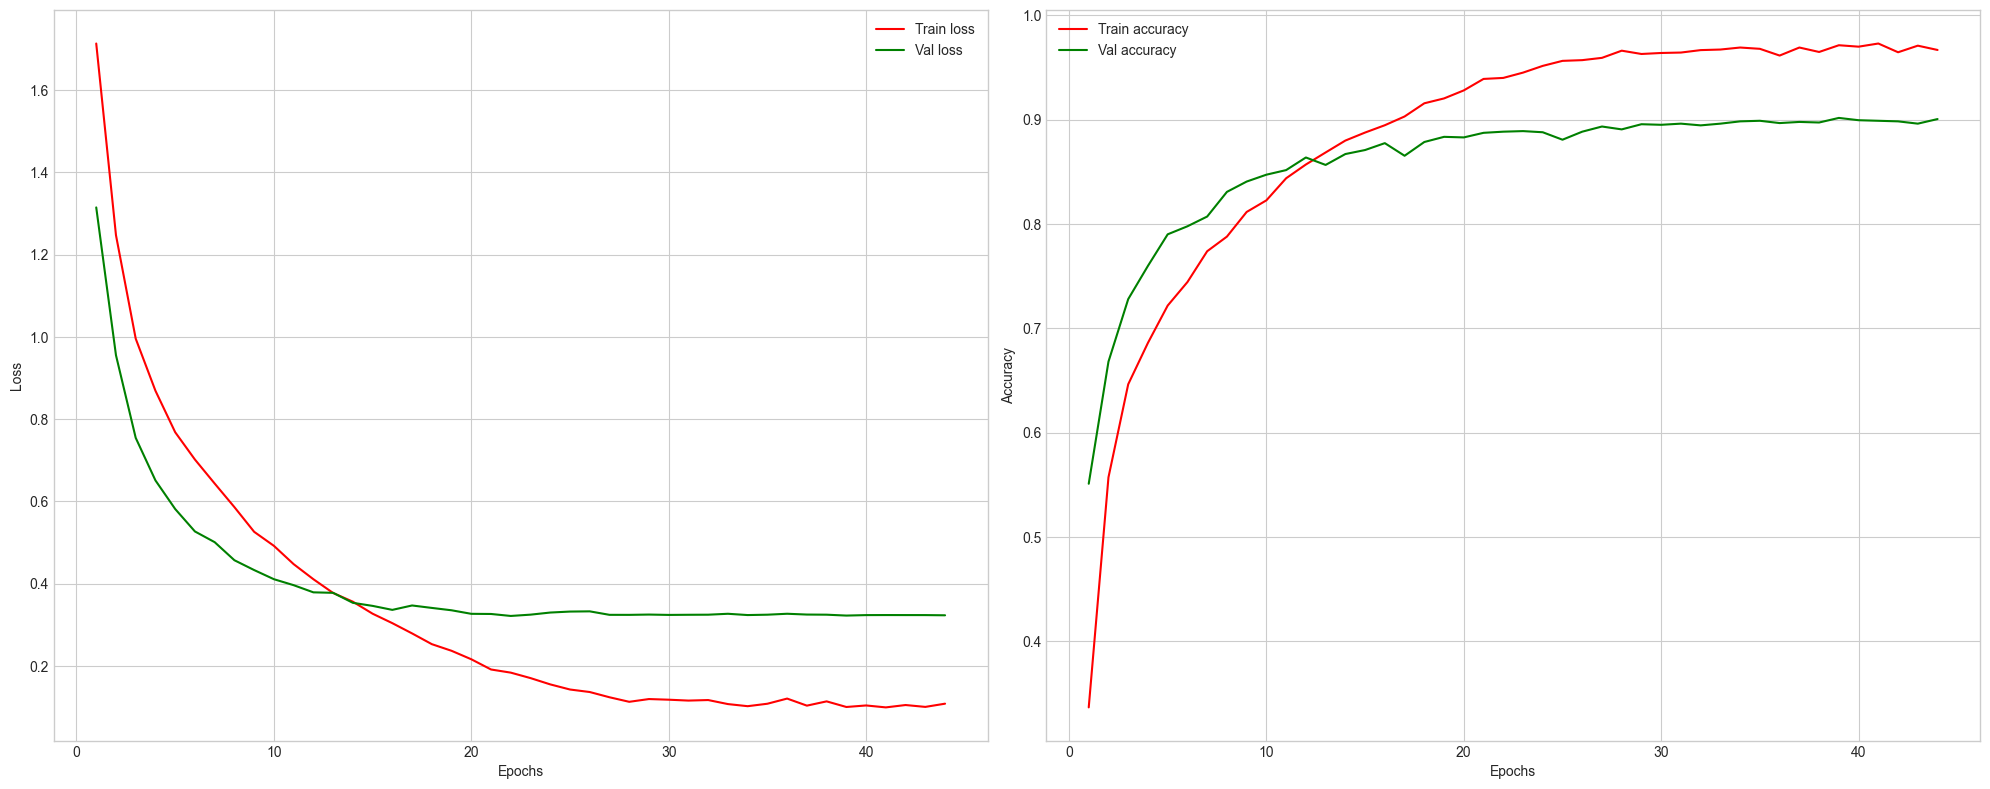

In [21]:
efficientnet_balanced_model_ft = train_model("EfficientNet-balanced-ft", models_folder, efficientnet_balanced_model_ft, data_augmentation, efficientnet_balanced_x_train, efficientnet_balanced_y_train, efficientnet_balanced_x_val, efficientnet_balanced_y_val, batch_size_ft, epochs)

228/228 ━━━━━━━━━━━━━━━━━━━━ 111s 487ms/step - loss: 0.2977 - sparse_categorical_accuracy: 0.9092
126/126 ━━━━━━━━━━━━━━━━━━━━ 60s 476ms/step - loss: 0.6950 - sparse_categorical_accuracy: 0.8038
Val loss: 0.3221854865550995, Val accuracy: 0.9016483426094055
Test loss: 0.6359841227531433, Test accuracy: 0.8183632493019104
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 466ms/step


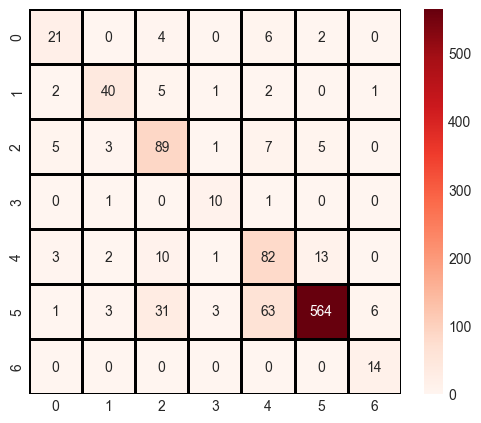

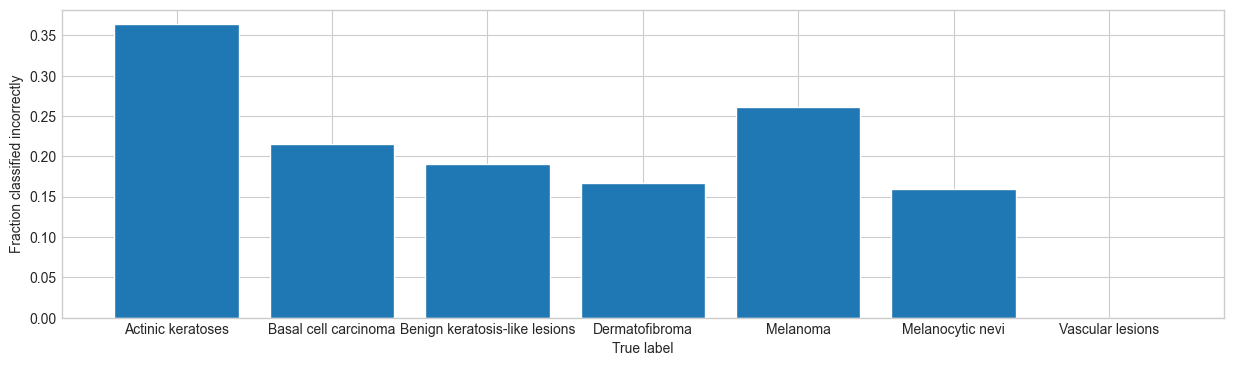

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.66      0.64      0.65        33
         Basal cell carcinoma       0.82      0.78      0.80        51
Benign keratosis-like lesions       0.64      0.81      0.71       110
               Dermatofibroma       0.62      0.83      0.71        12
                     Melanoma       0.51      0.74      0.60       111
             Melanocytic nevi       0.97      0.84      0.90       671
             Vascular lesions       0.67      1.00      0.80        14

                     accuracy                           0.82      1002
                    macro avg       0.70      0.81      0.74      1002
                 weighted avg       0.85      0.82      0.83      1002



In [22]:
evaluate_model(efficientnet_balanced_model_ft, batch_size_ft, efficientnet_balanced_x_val, efficientnet_balanced_y_val, efficientnet_x_test, efficientnet_y_test, categories, encodings)

### MobileNet

In [21]:
mobilenet_balanced_model_ft = create_model("mobilenet", mobilenet_balanced_x_train, classes=len(categories), trainable_encoder=True)

mobilenet_balanced_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

mobilenet_balanced_model_ft.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ adjust_input        │ (None, 224, 224,  │          0 │ input[0][0]       │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ adjust_input[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 2,232,839 (8.52 MB)

 Non-trainable params: 34,112 (133.25 KB)

Epoch 1/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - loss: 2.0094 - sparse_categorical_accuracy: 0.2494
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.43462, saving model to .\models\MobileNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 705s 743ms/step - loss: 2.0091 - sparse_categorical_accuracy: 0.2495 - val_loss: 1.5084 - val_sparse_categorical_accuracy: 0.4346 - learning_rate: 1.0000e-05
Epoch 2/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - loss: 1.3094 - sparse_categorical_accuracy: 0.5093
Epoch 2: val_sparse_categorical_accuracy improved from 0.43462 to 0.61758, saving model to .\models\MobileNet-balanced-ft\trained_model.keras
910/910 ━━━━━━━━━━━━━━━━━━━━ 853s 938ms/step - loss: 1.3093 - sparse_categorical_accuracy: 0.5093 - val_loss: 1.0280 - val_sparse_categorical_accuracy: 0.6176 - learning_rate: 1.0000e-05
Epoch 3/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - loss: 1.0932 - sparse_categorical_accuracy: 0.6047
Epoch 3: val_sparse_c

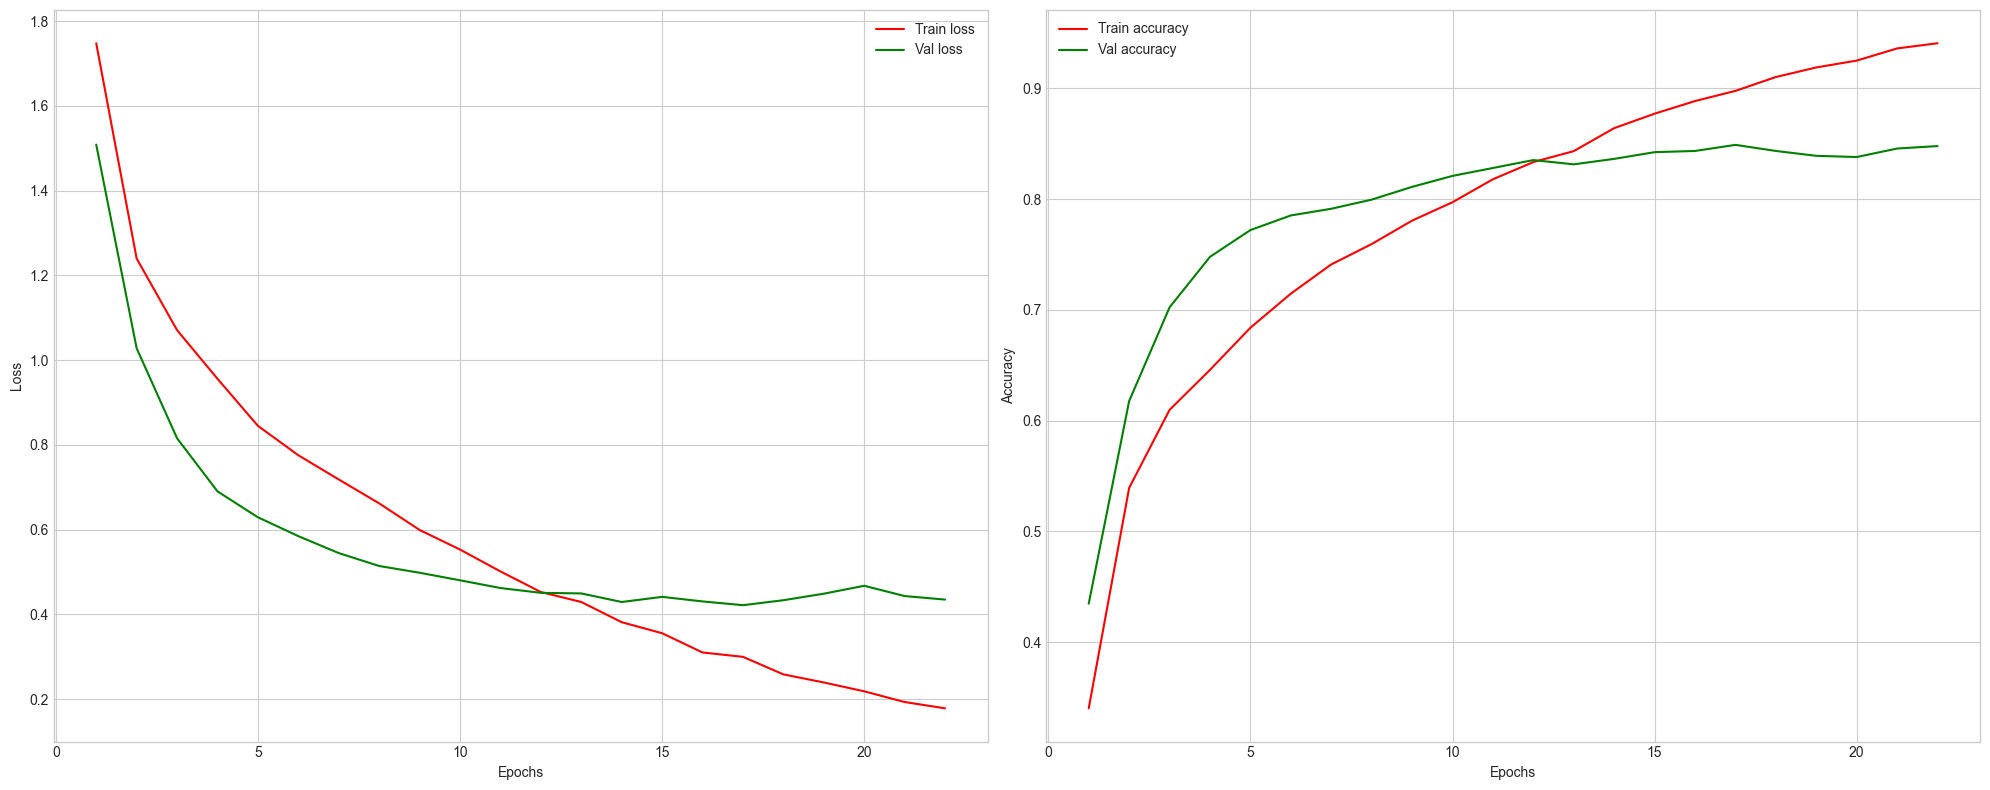

In [22]:
mobilenet_balanced_model_ft = train_model("MobileNet-balanced-ft", models_folder, mobilenet_balanced_model_ft, data_augmentation, mobilenet_balanced_x_train, mobilenet_balanced_y_train, mobilenet_balanced_x_val, mobilenet_balanced_y_val, batch_size_ft, epochs)

228/228 ━━━━━━━━━━━━━━━━━━━━ 33s 145ms/step - loss: 0.4253 - sparse_categorical_accuracy: 0.8422
126/126 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - loss: 0.7112 - sparse_categorical_accuracy: 0.7584
Val loss: 0.42195022106170654, Val accuracy: 0.848901093006134
Test loss: 0.6993999481201172, Test accuracy: 0.7674650549888611
126/126 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step


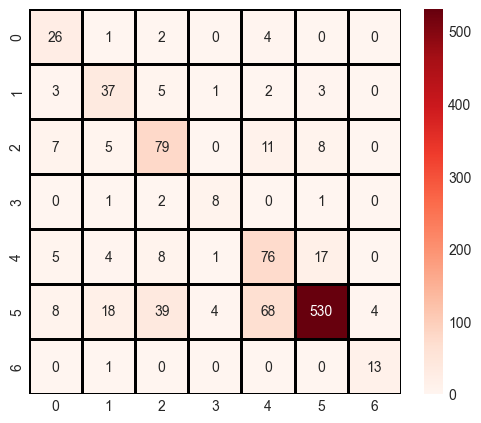

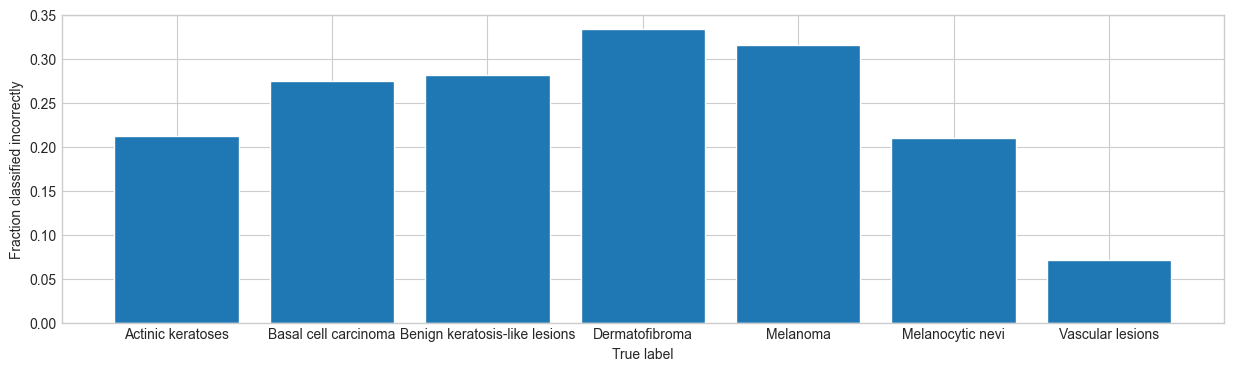

Classification Report:
                               precision    recall  f1-score   support

            Actinic keratoses       0.53      0.79      0.63        33
         Basal cell carcinoma       0.55      0.73      0.63        51
Benign keratosis-like lesions       0.59      0.72      0.64       110
               Dermatofibroma       0.57      0.67      0.62        12
                     Melanoma       0.47      0.68      0.56       111
             Melanocytic nevi       0.95      0.79      0.86       671
             Vascular lesions       0.76      0.93      0.84        14

                     accuracy                           0.77      1002
                    macro avg       0.63      0.76      0.68      1002
                 weighted avg       0.81      0.77      0.78      1002



In [23]:
evaluate_model(mobilenet_balanced_model_ft, batch_size_ft, mobilenet_balanced_x_val, mobilenet_balanced_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)

### VGG16

In [ ]:
vgg16_balanced_model_ft = create_model("vgg16", vgg16_balanced_x_train, classes=len(categories), trainable_encoder=True)

vgg16_balanced_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

vgg16_balanced_model_ft.summary()

In [ ]:
vgg16_balanced_model_ft = train_model("VGG16-balanced-ft", models_folder, vgg16_balanced_model_ft, data_augmentation, vgg16_balanced_x_train, vgg16_balanced_y_train, vgg16_balanced_x_val, vgg16_balanced_y_val, batch_size_ft, epochs)

In [ ]:
evaluate_model(vgg16_balanced_model_ft, batch_size_ft, vgg16_balanced_x_val, vgg16_balanced_y_val, vgg16_x_test, vgg16_y_test, categories, encodings)

### InceptionV3

In [ ]:
inceptionv3_balanced_model_ft = create_model("inceptionv3", inceptionv3_balanced_x_train, classes=len(categories), trainable_encoder=True)

inceptionv3_balanced_model_ft.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])
inceptionv3_balanced_model_ft.summary()

In [ ]:
inceptionv3_balanced_model_ft = train_model("InceptionV3-balanced-ft", models_folder, inceptionv3_balanced_model_ft, data_augmentation, inceptionv3_balanced_x_train, inceptionv3_balanced_y_train, inceptionv3_balanced_x_val, inceptionv3_balanced_y_val, batch_size_ft, epochs)

In [ ]:
evaluate_model(inceptionv3_balanced_model_ft, batch_size_ft, inceptionv3_balanced_x_val, inceptionv3_balanced_y_val, inceptionv3_x_test, inceptionv3_y_test, categories, encodings)

## Data augmentation

In [ ]:
data_augmentation = True

In [ ]:
mobilenet_balanced_model_ft_aug = create_model("mobilenet", mobilenet_balanced_x_train, classes=len(categories), trainable_encoder=True)

mobilenet_balanced_model_ft_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_lr_ft),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

mobilenet_balanced_model_ft_aug.summary()

In [ ]:
mobilenet_balanced_model_ft_aug = train_model("MobileNet-balanced-ft-aug", models_folder, mobilenet_balanced_model_ft_aug, data_augmentation, mobilenet_balanced_x_train, mobilenet_balanced_y_train, mobilenet_balanced_x_val, mobilenet_balanced_y_val, batch_size_ft, epochs)

In [ ]:
evaluate_model(mobilenet_balanced_model_ft_aug, batch_size_ft, mobilenet_balanced_x_val, mobilenet_balanced_y_val, mobilenet_x_test, mobilenet_y_test, categories, encodings)